## Predicting House Property Sales

This assignment focuses on building a time series model using a recurrent neural network (RNN) to predict house property sales.

### Dataset

You may reference the dataset available on Kaggle:
[Property Sales Dataset](https://www.kaggle.com/datasets/htagholdings/property-sales)

Use the `ma_lga_12345.csv` file for your analysis. Alternatively, you may use `raw_sales.csv` if you prefer.

### Assignment Specifications

- Implement at least **one recurrent neural network model** (e.g., `SimpleRNN`, `LSTM`, etc.) to predict **Sales**.
- **Important**: Since this is a time series task, do not split your data randomly. Maintain the temporal structure in your train-test splits.
- One of the goals is to explore the nuances of temporal prediction.

### Required Experiments

1. **Train-Test Splits**
   - Experiment with at least **three different train-test splits** that preserve the chronological order of data.

2. **Historical Data Input**
   - Experiment with at least **three different values** for the number of historical time steps used as input to the model (e.g., 1-step, 2-step, 3-step history).
   - Preprocessing may differ depending on the RNN architecture you choose.

3. **Visualization**
   - Plot your results, showing raw data overlaid with predictions.

In [29]:
from keras.src.initializers import GlorotUniform
# Data handling
import pandas as pd
import numpy as np

# For reproducibility
import random
import tensorflow as tf
import keras
from matplotlib import cm
from sklearn.model_selection import TimeSeriesSplit

# Set random seeds for consistency
np.random.seed(100)
tf.random.set_seed(100)
random.seed(100)
seeded_init = GlorotUniform(seed=100)

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Deep Learning (TensorFlow / Keras)
from keras.models import Sequential
from keras.layers import Dense, LSTM, SimpleRNN, GRU, Input
from keras.callbacks import EarlyStopping

# Utility for time series processing
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

# Date handling (if necessary)
import datetime

## The Data

In [30]:
# Load the dataset
df = pd.read_csv('Data/ma_lga_12345.csv')
df = df.sort_values('saledate')

# Quick preview
print(df.columns)
df.head()

Index(['saledate', 'MA', 'type', 'bedrooms'], dtype='object')


,saledate,MA,type,bedrooms
248,30/06/2007,368817,unit,2
101,30/06/2007,548969,house,4
50,30/06/2007,421291,house,3
202,30/06/2008,326076,unit,1
3,30/06/2008,441854,house,2


In [52]:
pd.to_datetime(df['saledate'], dayfirst=True).dt.year.value_counts()

saledate
2008    28
2010    28
2009    28
2011    28
2012    28
2016    28
2013    28
2014    28
2015    28
2018    28
2017    28
2019    21
2007    18
Name: count, dtype: int64

In [31]:
df_house = df[df['type'] == 'house']
df_house.describe()["MA"].round()

count        200.0
mean      627798.0
std       166728.0
min       416031.0
25%       485621.0
50%       584932.0
75%       771232.0
max      1017752.0
Name: MA, dtype: float64

In [33]:
df_unit = df[df['type'] == 'unit']
df_unit.describe()["MA"].round()

count       147.0
mean     439743.0
std      101158.0
min      316751.0
25%      339172.0
50%      425922.0
75%      533025.0
max      622045.0
Name: MA, dtype: float64

### Exploring the Data

Before building our forecasting models, we began by exploring the structure and contents of our dataset. The dataset includes four columns:
- `saledate`: the date the property was sold
- `MA`: the smoothed median sale price, used as our target for prediction
- `type`: whether the property is a house or a unit
- `bedrooms`: the number of bedrooms in the property

We noticed that the data spans from mid-2007 through 2019, with most years containing 28 quarterly entries. This consistency suggests the dataset has been regularly aggregated over time, which is ideal for building time series models.

Next, we examined the distribution of sale prices. For houses, the median smoothed sale price (MA) is around 585,000 while for units it’s lower, around 426,000. As expected, houses tend to sell for more than units, and there's a reasonable spread in prices across the years. We also noted that there are slightly fewer data points toward the start and end of the time range, which is common in time series when the data is trimmed or just beginning to be collected.

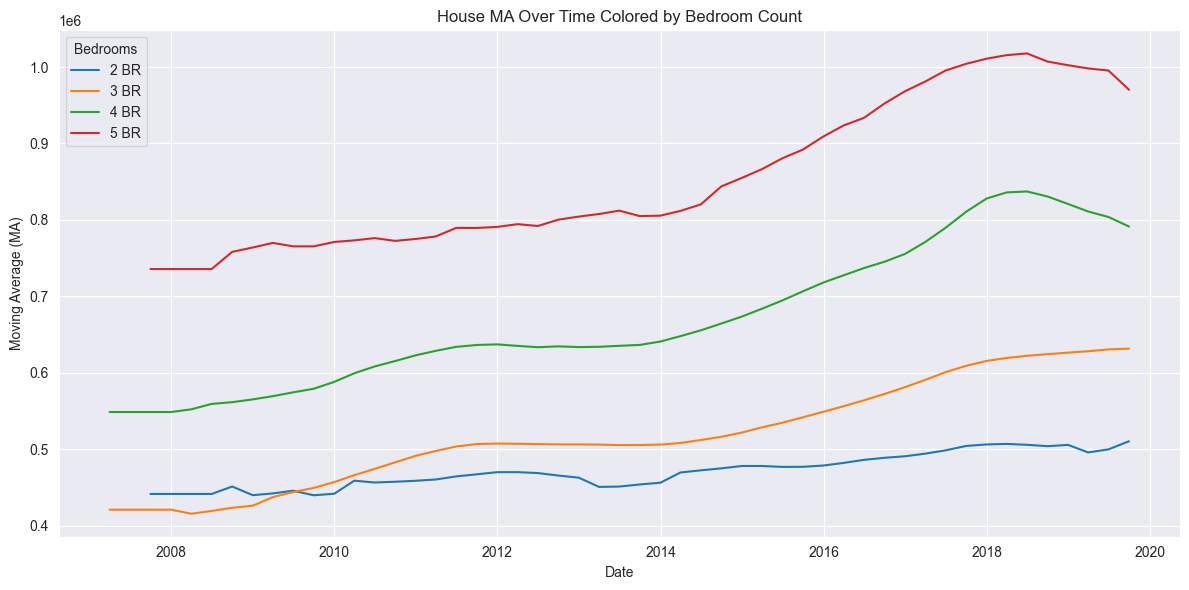

In [53]:
df_house.loc[:, 'saledate'] = pd.to_datetime(df_house['saledate'], dayfirst=True)

df_house = df_house.sort_values('saledate')

# Set figure
plt.figure(figsize=(12, 6))

# Loop through each bedroom count
for bedroom, group in df_house.groupby('bedrooms'):
    plt.plot(group['saledate'], group['MA'], label=f'{bedroom} BR')

plt.xlabel('Date')
plt.ylabel('Moving Average (MA)')
plt.title('House MA Over Time Colored by Bedroom Count')
plt.legend(title='Bedrooms')
plt.grid(True)
plt.tight_layout()
plt.show()

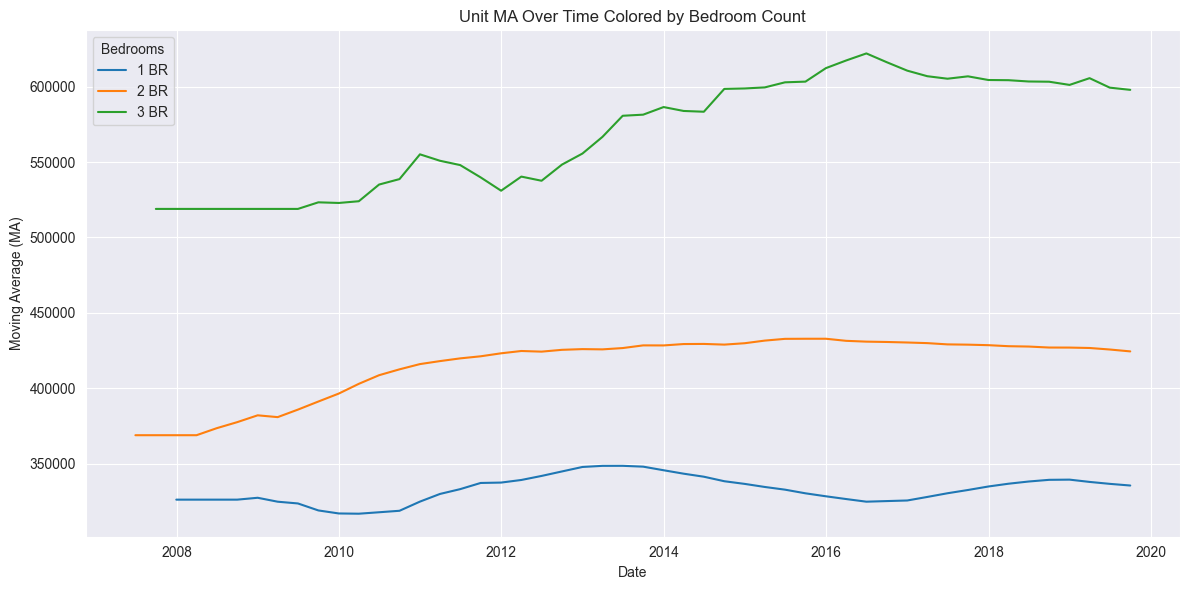

In [54]:
df_unit.loc[:, 'saledate'] = pd.to_datetime(df_unit['saledate'], dayfirst=True)

df_unit = df_unit.sort_values('saledate')

# Set figure
plt.figure(figsize=(12, 6))

# Loop through each bedroom count
for bedroom, group in df_unit.groupby('bedrooms'):
    plt.plot(group['saledate'], group['MA'], label=f'{bedroom} BR')

plt.xlabel('Date')
plt.ylabel('Moving Average (MA)')
plt.title('Unit MA Over Time Colored by Bedroom Count')
plt.legend(title='Bedrooms')
plt.grid(True)
plt.tight_layout()
plt.show()

### Visualizing Property Prices Over Time by Bedroom Count

To better understand the trends in our data, we visualized the smoothed median property prices (MA) over time, grouped by the number of bedrooms.

In the first plot, we focus on **houses**. As expected, houses with more bedrooms consistently sell for higher prices. The lines show a steady upward trend over time, particularly for 4-bedroom and 5-bedroom homes, which saw the steepest price growth between 2015 and 2018. This suggests strong demand for larger homes in recent years. Even 2- and 3-bedroom houses show growth, but at a slower rate and lower price level.

In the second plot, we examine **units**. These follow a similar pattern, though at a lower price level overall. Larger units (with 3 bedrooms) tend to have higher prices, but unlike houses, price growth for smaller units appears to have leveled off or even declined slightly after 2016. This could indicate saturation or shifting preferences in the unit market.

Together, these plots help us confirm that:
- Price behavior varies between houses and units, and their sizes
- Time-based patterns are clearly present and meaningful


## Modeling

### Preparing the Data for the Neural Network

Time series models need structured input to learn from past patterns. The `create_sequences` function transforms our timeline of values into smaller chunks (or "windows") of past data. For example, if we set a history length of 3, the model will learn to predict the next value based on the previous 3 values. This step is essential to teaching the model how past property prices relate to future prices.

In [ ]:
def create_sequences(data, steps):
    X, y = [], []
    for i in range(steps, len(data)):
        X.append(data[i-steps:i])
        y.append(data[i])
    return np.array(X), np.array(y)

### Building and Running Our Forecasting Model

This function handles the full forecasting process for one specific group (such as 1-bedroom units). First, it prepares the data, then it trains a neural network model (either a basic RNN or an LSTM, which is a type of RNN that's good at handling sequences). The model learns how past house prices relate to future prices. After training, the model's predictions are compared to actual values using a standard error measure (RMSE), and the results are visualized over time. This helps us see how well the model performs.

In [ ]:
def run_simple_forecast(df_group, group_name, history_steps=4, split_ratio=0.8, epochs=50, use_rnn=False, ax=None):
    df_group = df_group.copy()
    df_group['saledate'] = pd.to_datetime(df_group['saledate'], dayfirst=True)
    df_group = df_group.sort_values('saledate')
    df_group.set_index('saledate', inplace=True)
    values = df_group[['MA']].values
    dates = df_group.index.values

    # Normalize values
    scaler = MinMaxScaler()
    scaled_values = scaler.fit_transform(values)

    # Create sequences
    X, y = create_sequences(scaled_values, history_steps)
    date_targets = dates[history_steps:]

    # Train/test split (time-based)
    split_idx = int(len(X) * split_ratio)
    X_train, X_test = X[:split_idx], X[split_idx:]
    y_train, y_test = y[:split_idx], y[split_idx:]
    train_dates = date_targets[:split_idx]
    test_dates = date_targets[split_idx:]

    # Reshape for RNN input
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
    X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

    # Define model
    seeded_init = GlorotUniform(seed=42)
    model = Sequential()
    model.add(Input(shape=(history_steps, 1)))
    if use_rnn:
        model.add(SimpleRNN(50, activation='relu', kernel_initializer=seeded_init))
    else:
        model.add(LSTM(4, activation='relu', kernel_initializer=seeded_init))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    model.fit(X_train, y_train, epochs=epochs, verbose=0)

    # Predict both train and test sets
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    y_train_pred_inv = scaler.inverse_transform(y_train_pred)
    y_train_inv = scaler.inverse_transform(y_train)
    y_test_pred_inv = scaler.inverse_transform(y_test_pred)
    y_test_inv = scaler.inverse_transform(y_test)

    # Compute RMSE on both train and test sets
    rmse_train = np.sqrt(mean_squared_error(y_train_inv, y_train_pred_inv))
    rmse_test = np.sqrt(mean_squared_error(y_test_inv, y_test_pred_inv))
    print(f'Train RMSE: {rmse_train:.2f} | Test RMSE: {rmse_test:.2f} | History Steps: {history_steps} | Train Size: {int(split_ratio * 100)}%')

    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 5))

    # Train + test predictions
    ax.plot(train_dates, y_train_inv, label='Actual Train', color='navy')
    ax.plot(train_dates, y_train_pred_inv, label='Predicted Train', color='skyblue')
    ax.plot(test_dates, y_test_inv, label='Actual Test', color='blue')
    ax.plot(test_dates, y_test_pred_inv, label='Predicted Test', color='orange')

    model_type = "SimpleRNN" if use_rnn else "LSTM"
    ax.set_title(f'{group_name} | {model_type} | History={history_steps} | Train={int(split_ratio*100)}%')
    ax.set_xlabel('Date')
    ax.set_ylabel('Price')
    ax.tick_params(axis='x', rotation=45)
    ax.grid(True)
    ax.legend()

### Comparing Different Model Settings

This function helps us compare model performance under different conditions. It runs multiple forecasts using different amounts of training data (split ratios) and different lengths of past history (number of quarters used to predict the next). Each combination is plotted in a separate panel so we can easily spot trends in how the model performs under each setting. This lets us explore which setup gives us the most reliable predictions.

In [35]:
# Auto-generate subplot comparisons
def plot_all_combos(df_filtered, group_label='Group', model_flag=True):
    splits = [0.6, 0.7, 0.8]
    steps_list = [1, 3, 5]

    fig, axes = plt.subplots(nrows=len(steps_list), ncols=len(splits), figsize=(18, 10), sharey=True)

    for row_idx, steps in enumerate(steps_list):
        for col_idx, split in enumerate(splits):
            ax = axes[row_idx, col_idx]
            run_simple_forecast(
                df_filtered,
                group_label,
                history_steps=steps,
                split_ratio=split,
                use_rnn=model_flag,
                ax=ax
            )

    plt.suptitle(f"{group_label} Forecasts by Split Ratio and History Steps", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

## Modeling Home Prices (By Size)

### 2-Bedroom Homes

#### RNN's

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
Train RMSE: 6303.95 | Test RMSE: 15040.21 | History Steps: 1 | Train Size: 60%
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Train RMSE: 8828.58 | Test RMSE: 17308.60 | History Steps: 1 | Train Size: 70%
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Train RMSE: 8366.05 | Test RMSE: 17268.38 | History Steps: 1 | Train Size: 80%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
Train RMSE: 6934.52 | Test RMSE: 11438.74 | History Steps: 3 | Train Size: 60%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
Train RMSE: 6189.28 | Test RMSE: 11906.39 | History Steps: 3 | Train Size: 70%
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Train RMSE: 5417.27 | Test RMSE: 7777.96 | History Steps: 3 | Train Size: 80%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms

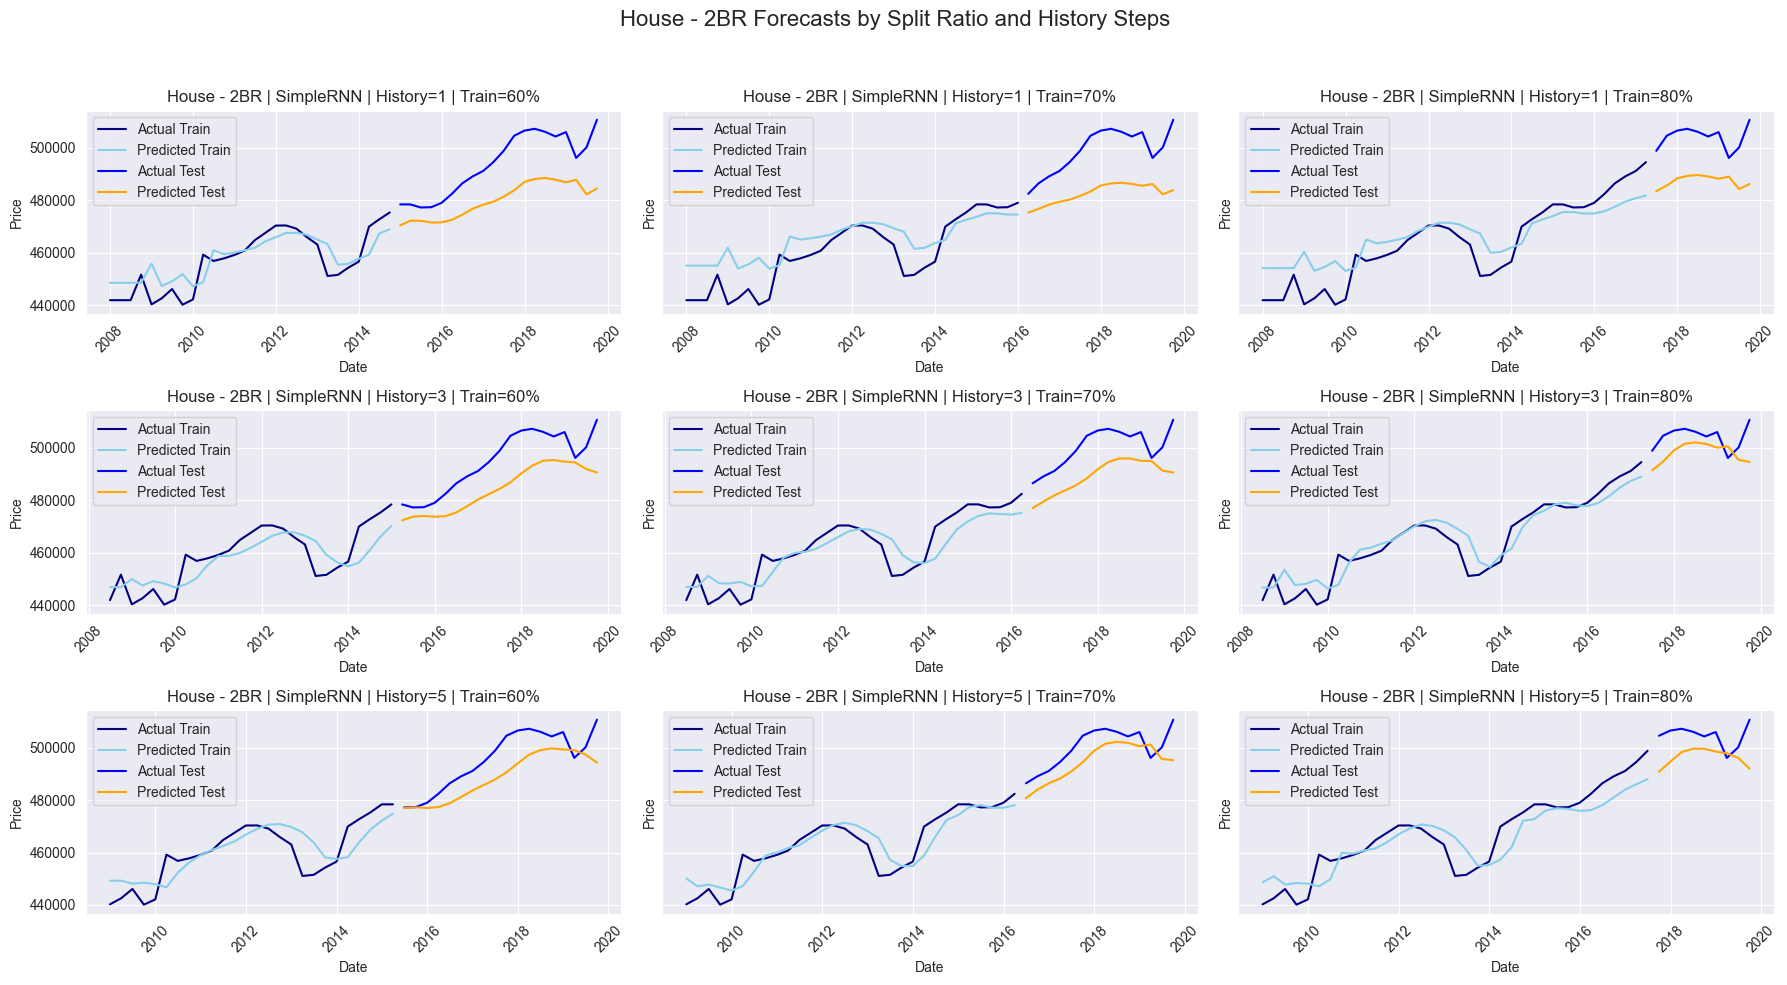

In [36]:
house2_df = df_house[df_house['bedrooms'] == 2]
plot_all_combos(house2_df, group_label='House - 2BR', model_flag=True)

#### LSTM's

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
Train RMSE: 17332.30 | Test RMSE: 52254.66 | History Steps: 1 | Train Size: 60%
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Train RMSE: 19739.53 | Test RMSE: 58216.16 | History Steps: 1 | Train Size: 70%
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Train RMSE: 16042.37 | Test RMSE: 40311.41 | History Steps: 1 | Train Size: 80%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
Train RMSE: 19574.87 | Test RMSE: 55747.38 | History Steps: 3 | Train Size: 60%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
Train RMSE: 22286.77 | Test RMSE: 57554.48 | History Steps: 3 | Train Size: 70%
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Train RMSE: 25824.28 | Test RMSE: 65287.79 | History Steps: 3 | Train Size: 80%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━

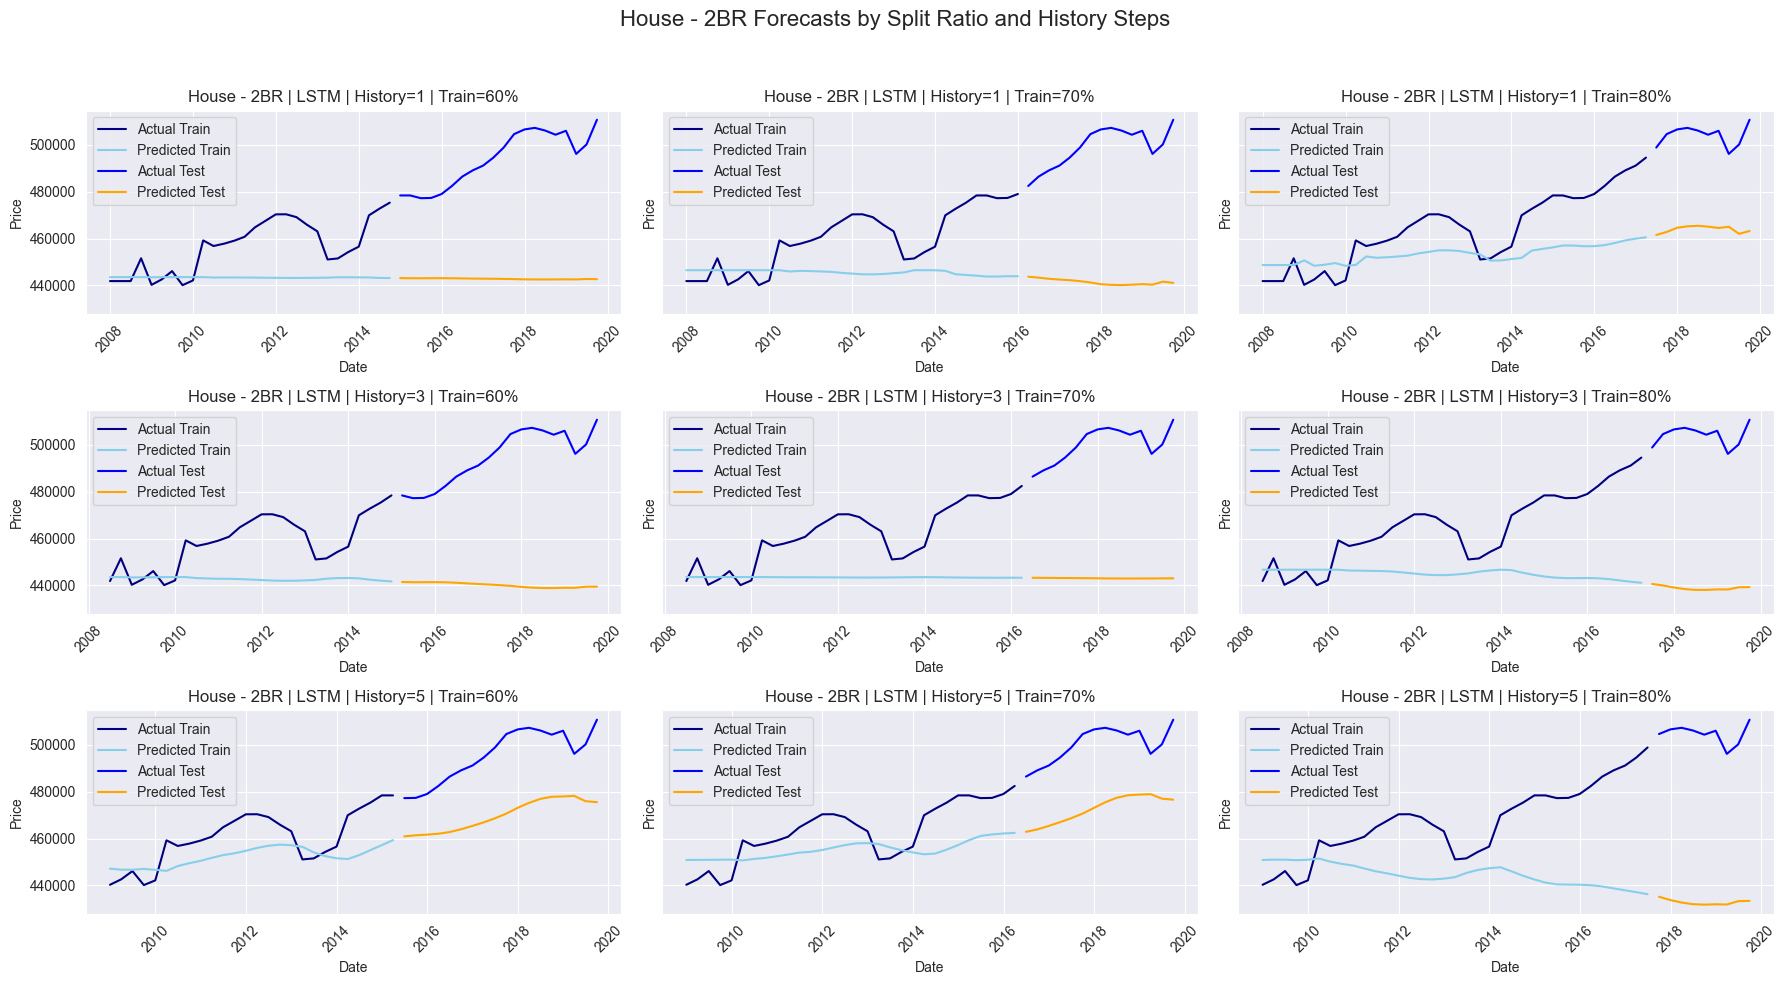

In [37]:
plot_all_combos(house2_df, group_label='House - 2BR', model_flag=False)

#### Observations on RNNs
RNN models performed reasonably well across all settings. The best performance was observed when using **longer history windows** (3 or 5 quarters) and **larger training sizes**. For example, using 5 steps of history and training on 70% of the data produced relatively low test RMSE values (~7133), and predictions tracked the actual trend smoothly.

#### Observations on LSTMs
LSTM results were more mixed. While LSTMs generally have the potential to outperform RNNs in time series tasks, they tended to **overfit** or struggle with very small training windows or short history sizes in our setup. Some test errors exceeded 60,000, especially for short histories and larger splits. One of the more stable results came from a 5-step history and a 60% train size, with test RMSE around 26,400 — still notably higher than the best RNN run.

#### Key Takeaways
- **Using more history helps**: Larger input windows generally improved predictions for both RNN and LSTM models.
- **More training data improves stability**, but for LSTMs, too large a split (e.g. 80%) sometimes led to poor generalization.
- **RNNs outperformed LSTMs** in this specific case, suggesting that for simpler, smoother time series like housing MA, complexity does not always guarantee better results.

### 3-Bedroom Homes

#### RNN's

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
Train RMSE: 16858.41 | Test RMSE: 55816.31 | History Steps: 1 | Train Size: 60%
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Train RMSE: 19051.21 | Test RMSE: 58502.34 | History Steps: 1 | Train Size: 70%
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Train RMSE: 10937.16 | Test RMSE: 26576.42 | History Steps: 1 | Train Size: 80%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
Train RMSE: 5341.46 | Test RMSE: 23464.07 | History Steps: 3 | Train Size: 60%
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Train RMSE: 5460.64 | Test RMSE: 19134.49 | History Steps: 3 | Train Size: 70%
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Train RMSE: 5241.74 | Test RMSE: 3820.61 | History Steps: 3 | Train Size: 80%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

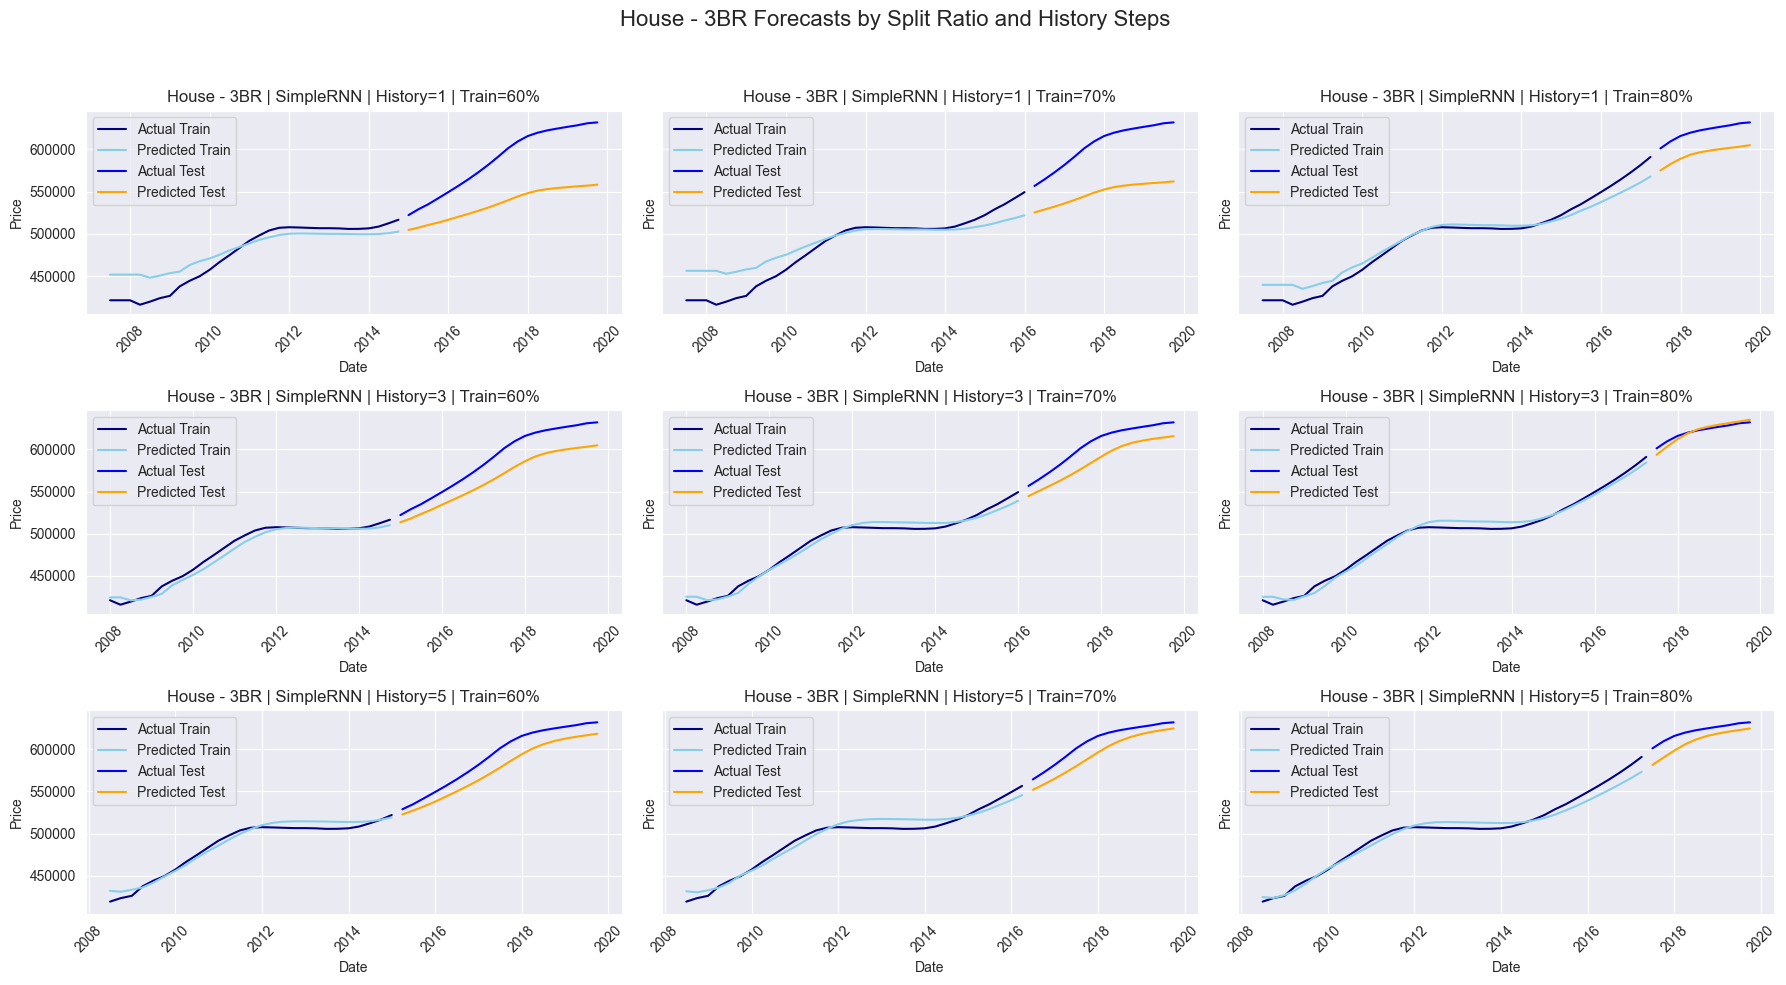

In [38]:
house3_df = df_house[df_house['bedrooms'] == 3]
plot_all_combos(house3_df, group_label='House - 3BR', model_flag=True)

#### LSTM's

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
Train RMSE: 47261.94 | Test RMSE: 129647.05 | History Steps: 1 | Train Size: 60%
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Train RMSE: 59488.67 | Test RMSE: 164092.05 | History Steps: 1 | Train Size: 70%
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Train RMSE: 67041.09 | Test RMSE: 164598.38 | History Steps: 1 | Train Size: 80%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
Train RMSE: 43298.67 | Test RMSE: 115716.12 | History Steps: 3 | Train Size: 60%
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Train RMSE: 67314.76 | Test RMSE: 183731.49 | History Steps: 3 | Train Size: 70%
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Train RMSE: 42390.42 | Test RMSE: 96079.21 | History Steps: 3 | Train Size: 80%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━

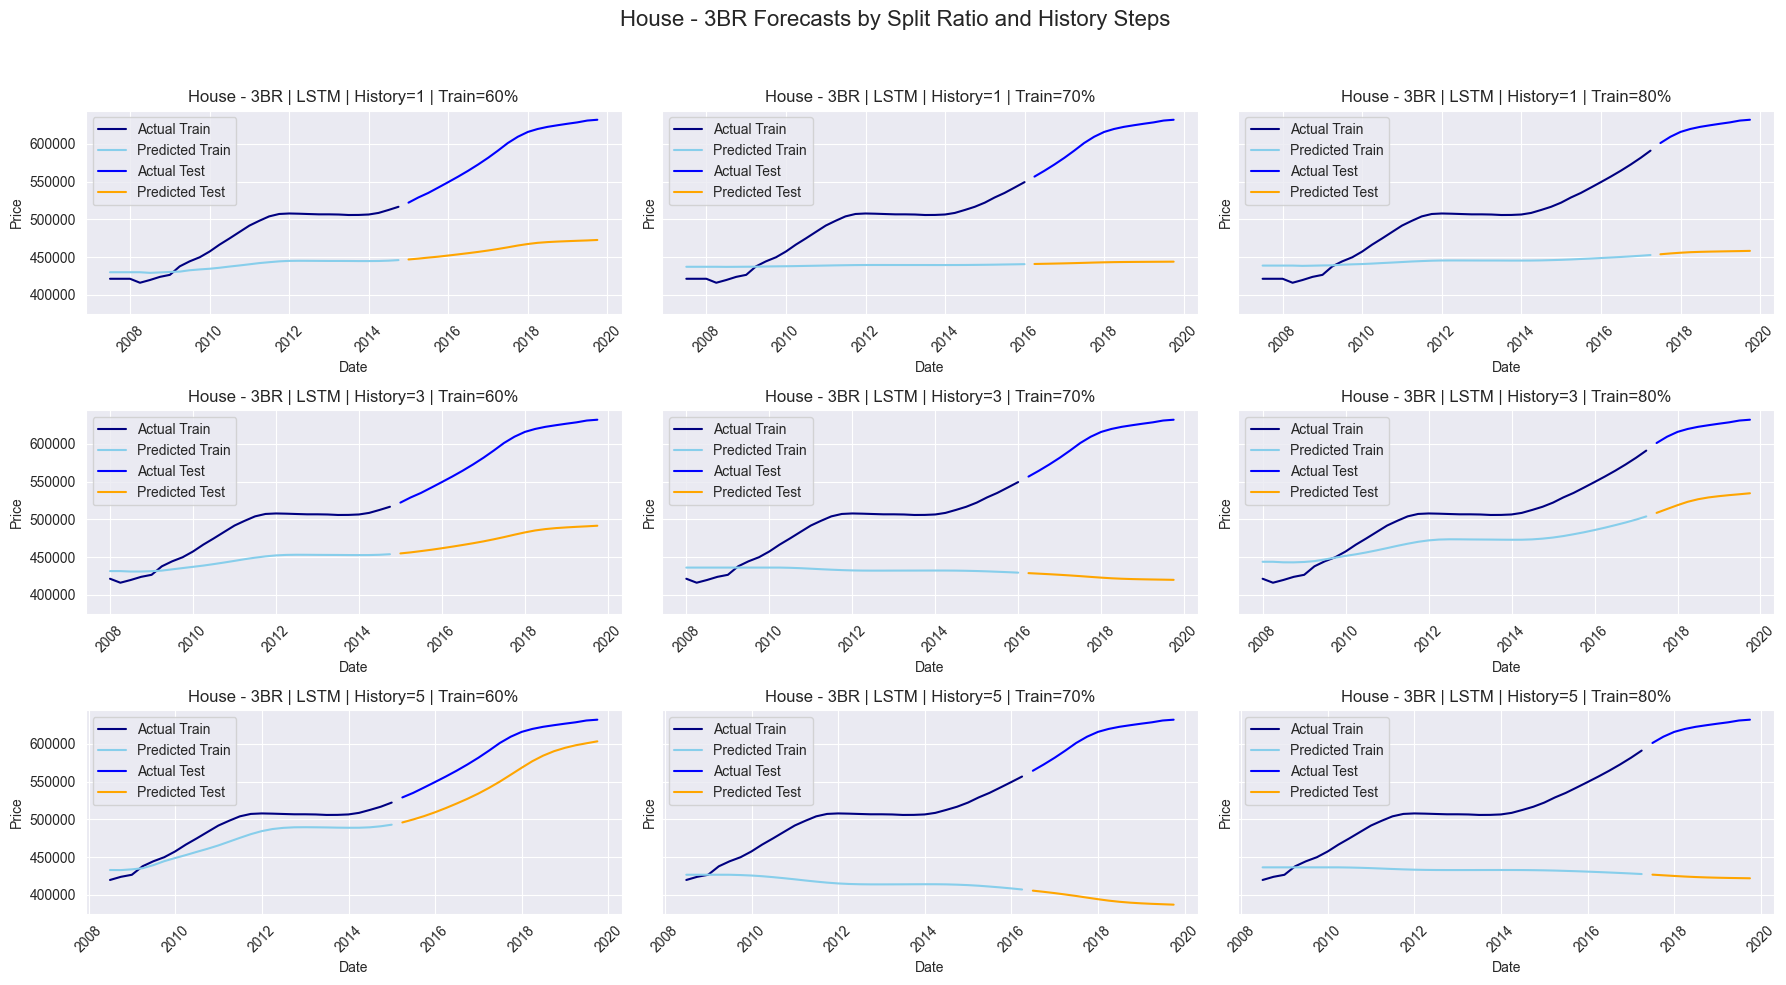

In [39]:
plot_all_combos(house3_df, group_label='House - 3BR', model_flag=False)

#### RNN Results

The RNN models showed strong performance across most settings, with visibly tight alignment between predicted and actual values — especially with longer history windows (3 or 5 steps). The lowest test error occurred using a 3-step history and an 80% training split, with a test RMSE of just **3,821**, indicating highly accurate predictions. Even smaller splits performed reasonably well with errors mostly under 25,000.

#### LSTM Results

The LSTM models struggled more significantly. In some settings, particularly with smaller history windows, the test error spiked dramatically. For example, a 1-step history with 80% training data yielded a test RMSE over **164,000**. That’s a clear indication the model failed to generalize. However, there were exceptions: the LSTM with a 5-step history and 60% training data gave a test RMSE of **40,606**, showing some promise when more past context was provided.

#### Key Takeaways

- For 3-bedroom houses, **Simple RNNs were far more stable and accurate** than LSTMs.
- **Increasing the amount of history consistently improved performance** for both models.
- LSTMs tended to **overfit or underperform** in this context, possibly due to the relatively small dataset and the smoothed nature of the MA series.

These findings suggest that for straightforward housing trends, simpler RNNs may be more reliable and interpretable than deeper models like LSTMs.

### 4 Bedroom Homes

#### RNN's

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
Train RMSE: 21654.08 | Test RMSE: 115436.67 | History Steps: 1 | Train Size: 60%
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Train RMSE: 20908.66 | Test RMSE: 86686.97 | History Steps: 1 | Train Size: 70%
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Train RMSE: 18381.47 | Test RMSE: 49644.14 | History Steps: 1 | Train Size: 80%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
Train RMSE: 4815.89 | Test RMSE: 24185.55 | History Steps: 3 | Train Size: 60%
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Train RMSE: 6286.02 | Test RMSE: 17762.48 | History Steps: 3 | Train Size: 70%
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Train RMSE: 6912.07 | Test RMSE: 25081.19 | History Steps: 3 | Train Size: 80%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

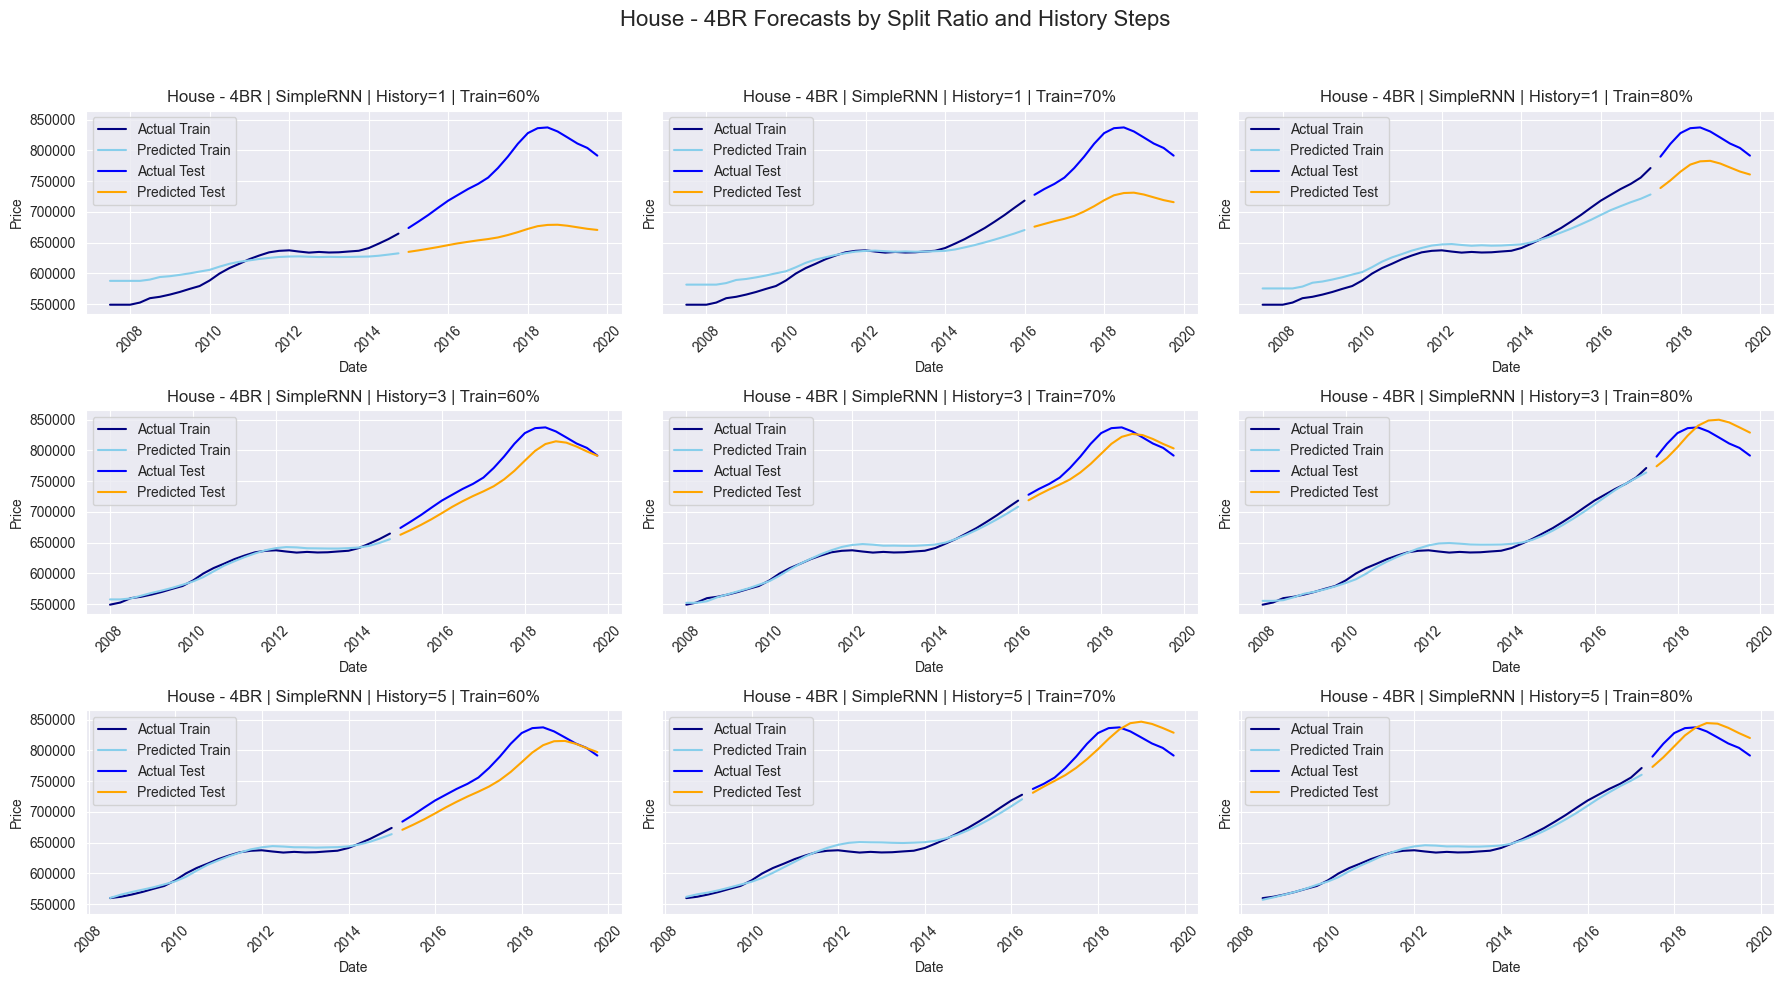

In [40]:
house4_df = df_house[df_house['bedrooms'] == 4]
plot_all_combos(house4_df, group_label='House - 4BR', model_flag=True)

#### LSTM's

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
Train RMSE: 59444.43 | Test RMSE: 220143.13 | History Steps: 1 | Train Size: 60%
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Train RMSE: 59581.87 | Test RMSE: 206069.29 | History Steps: 1 | Train Size: 70%
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Train RMSE: 90489.24 | Test RMSE: 260831.29 | History Steps: 1 | Train Size: 80%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
Train RMSE: 69382.87 | Test RMSE: 262682.39 | History Steps: 3 | Train Size: 60%
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Train RMSE: 30274.07 | Test RMSE: 97741.92 | History Steps: 3 | Train Size: 70%
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Train RMSE: 73103.20 | Test RMSE: 199728.97 | History Steps: 3 | Train Size: 80%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━

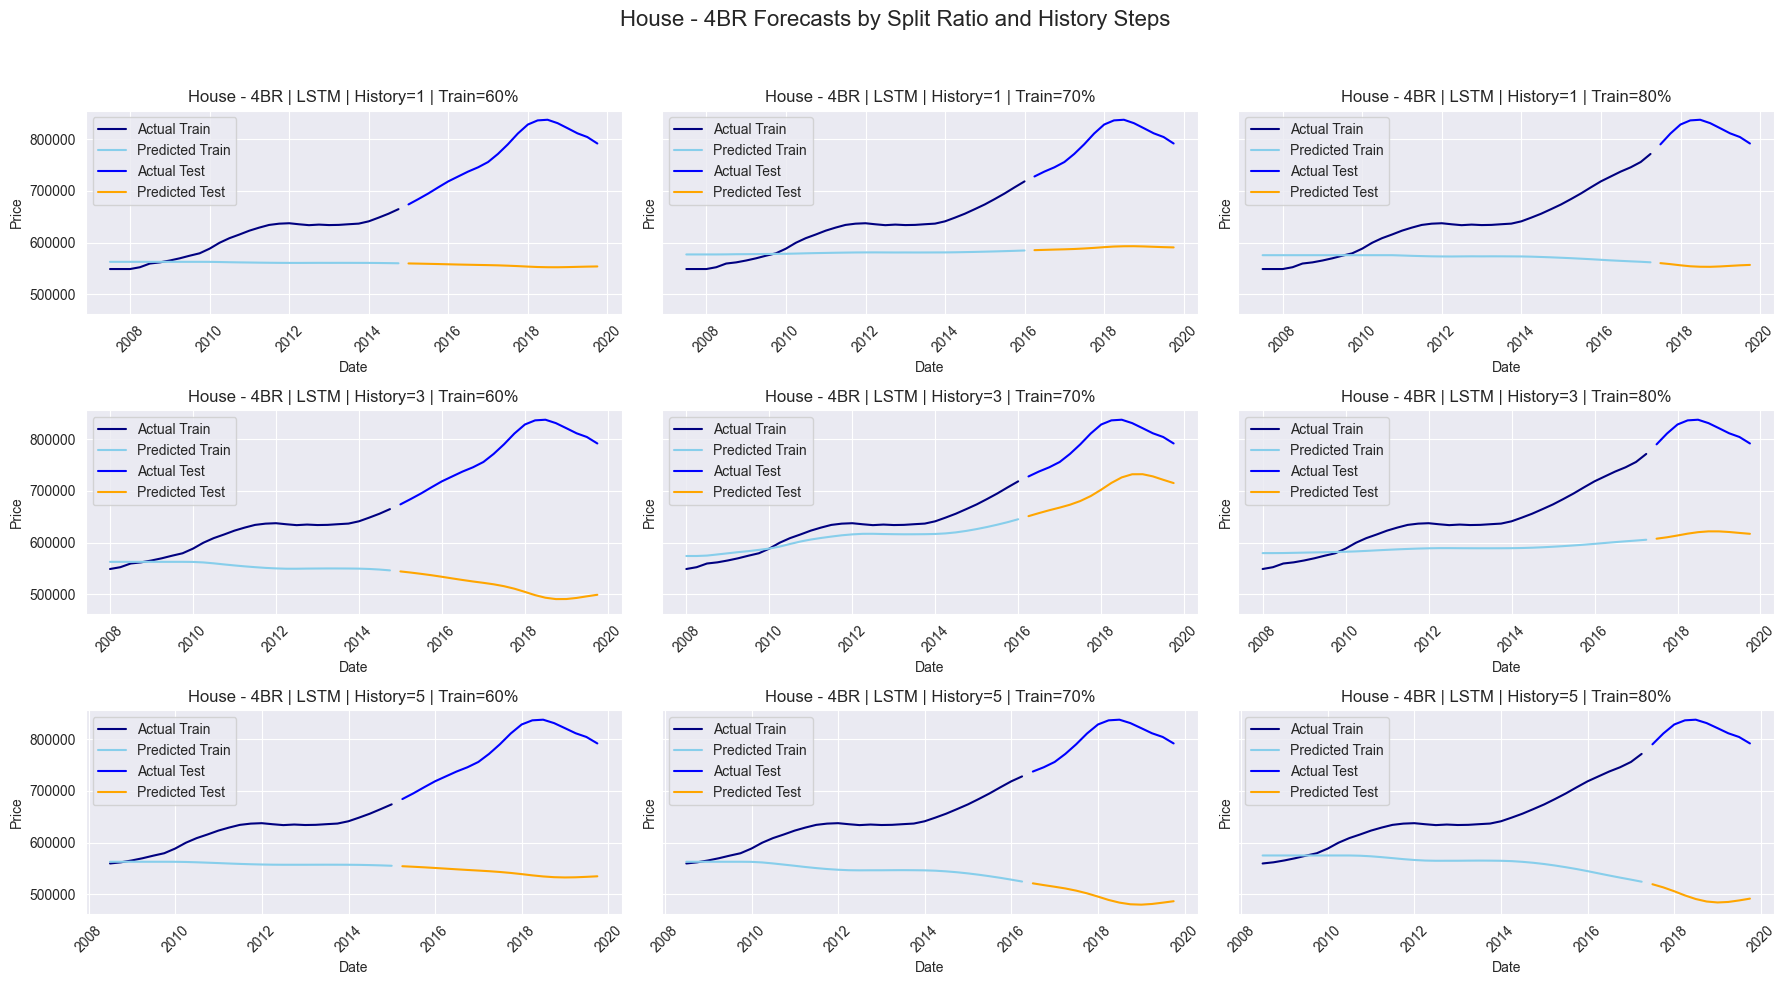

In [41]:
plot_all_combos(house4_df, group_label='House - 4BR', model_flag=False)

#### RNN Results

Simple RNN models again delivered strong results. All configurations with longer histories (3 or 5 past quarters) performed significantly better than those with only 1 history step. For example, using 3 history steps and 70% training data produced a **test RMSE of just 17,762**, and predictions followed actual trends very closely. Even the 5-step models across all splits remained consistent, with test RMSEs between **20,000 and 26,000**.

In contrast, the 1-step history models showed much higher errors, especially at lower train ratios. Still, even those models (e.g., RMSE ≈ 49,644 at 80% training) were notably better than the comparable LSTM results.

#### LSTM Results

LSTM models once again showed instability, especially with short history lengths. For instance, a 1-step model with 80% training yielded a **massive test RMSE of over 260,000**. Increasing the history steps to 3 or 5 helped slightly in some cases, but overall test performance remained weak and erratic. The lowest test error from an LSTM was **97,742** — still several times worse than the best RNN result.

#### Key Takeaways

- **RNNs consistently outperformed LSTMs** for this group of properties, across all tested configurations.
- **More history = better performance**: As seen with 2BR and 3BR homes, using more quarters of past data improves model learning.
- **LSTMs did not generalize well** on this data, possibly due to overfitting or sensitivity to the smoothed nature of the MA feature.

At this point in our analysis, it is increasingly clear that Simple RNNs are more appropriate for this kind of problem. The data’s regularity and lack of high-frequency noise may favor simpler architectures that don't require as much regularization or memory management as LSTMs provide.

### 5 Bedroom Homes

#### RNN's

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
Train RMSE: 14300.32 | Test RMSE: 100067.15 | History Steps: 1 | Train Size: 60%
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Train RMSE: 31197.56 | Test RMSE: 114909.04 | History Steps: 1 | Train Size: 70%
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Train RMSE: 31702.70 | Test RMSE: 64985.65 | History Steps: 1 | Train Size: 80%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
Train RMSE: 9331.37 | Test RMSE: 49157.05 | History Steps: 3 | Train Size: 60%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
Train RMSE: 14285.50 | Test RMSE: 27016.76 | History Steps: 3 | Train Size: 70%
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Train RMSE: 6850.64 | Test RMSE: 42631.39 | History Steps: 3 | Train Size: 80%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━

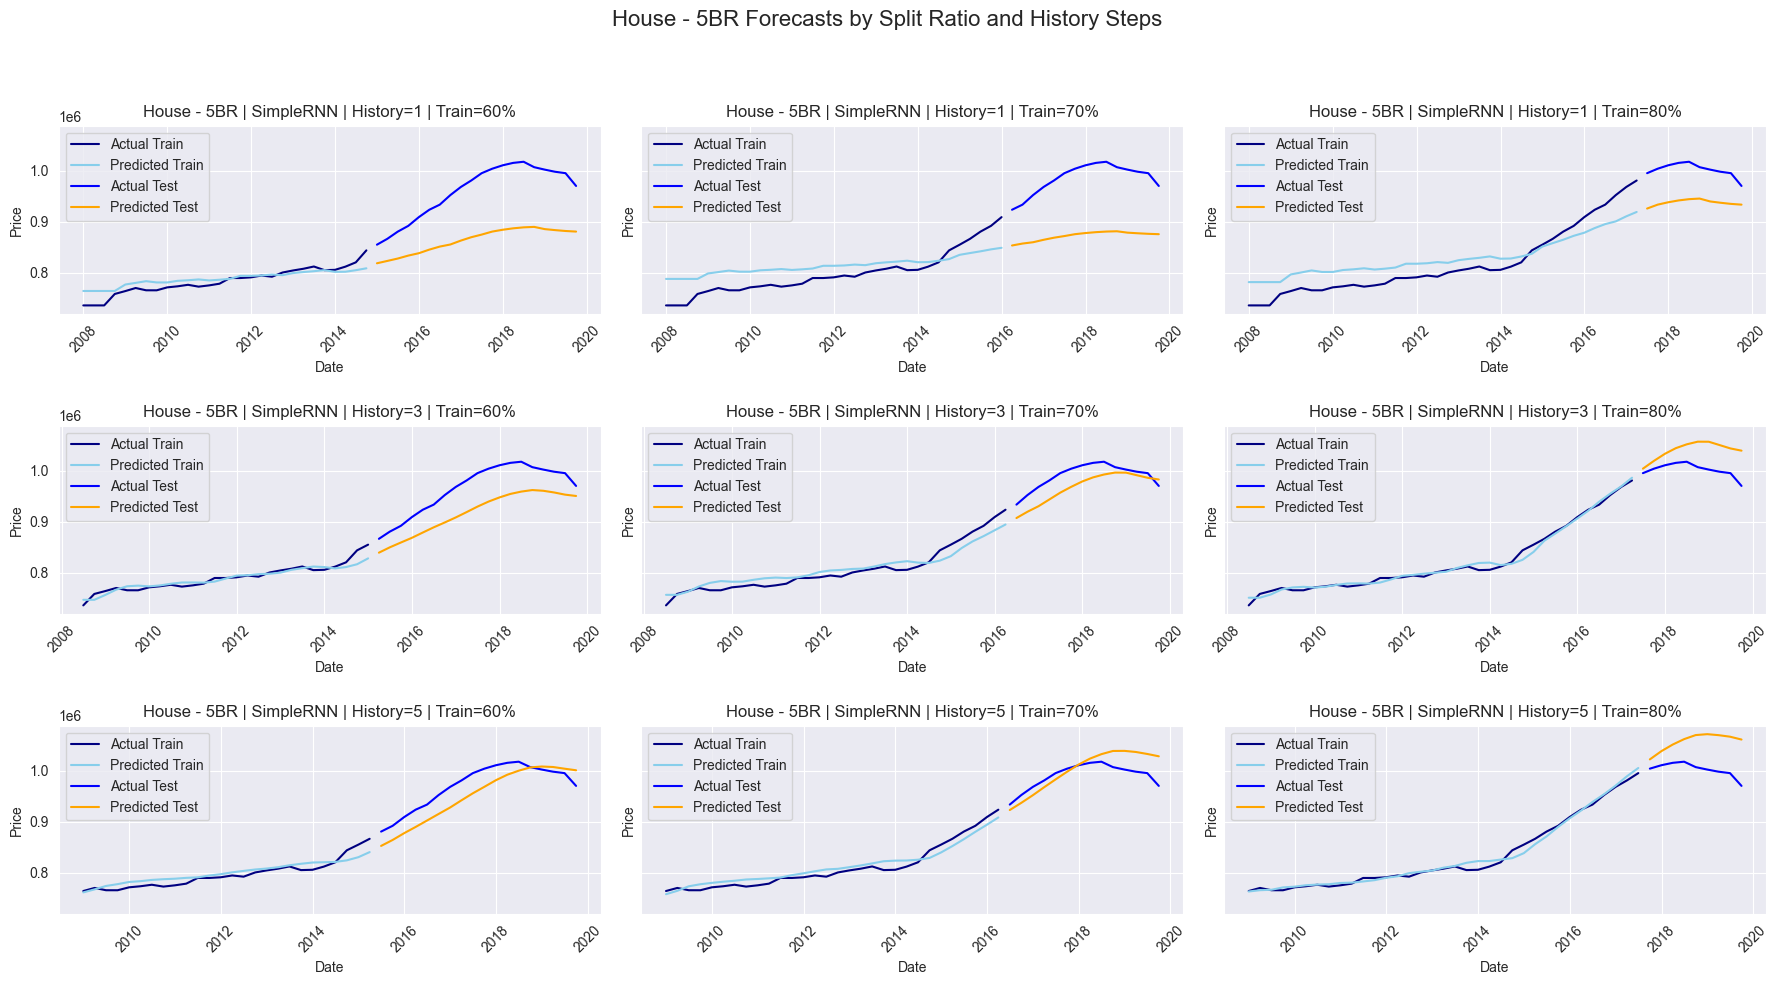

In [42]:
house5_df = df_house[df_house['bedrooms'] == 5]
plot_all_combos(house5_df, group_label='House - 5BR', model_flag=True)

#### LSTM's

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
Train RMSE: 38019.52 | Test RMSE: 194484.69 | History Steps: 1 | Train Size: 60%
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Train RMSE: 57866.77 | Test RMSE: 234306.56 | History Steps: 1 | Train Size: 70%
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Train RMSE: 90721.69 | Test RMSE: 254866.42 | History Steps: 1 | Train Size: 80%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
Train RMSE: 55221.15 | Test RMSE: 275378.58 | History Steps: 3 | Train Size: 60%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
Train RMSE: 74189.16 | Test RMSE: 248573.20 | History Steps: 3 | Train Size: 70%
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Train RMSE: 56489.52 | Test RMSE: 143950.54 | History Steps: 3 | Train Size: 80%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━

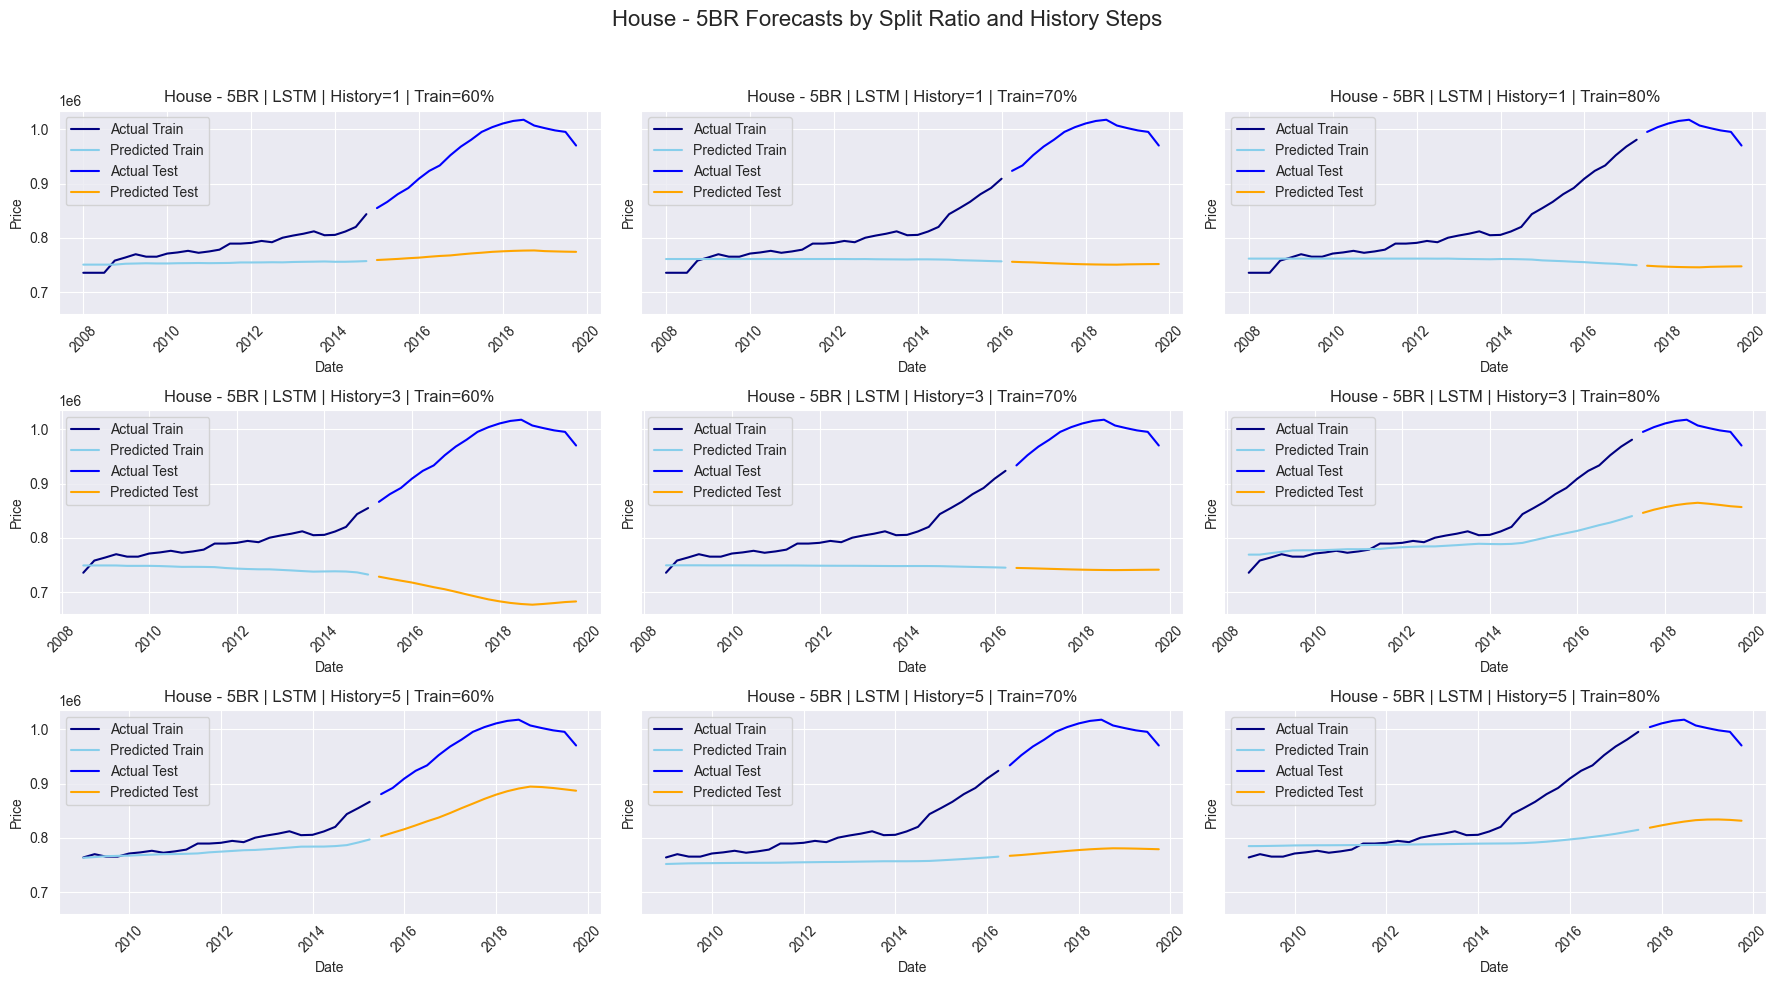

In [43]:
plot_all_combos(house5_df, group_label='House - 5BR', model_flag=False)

#### RNN Results

Simple RNNs continued to show solid performance. With a longer historical context (e.g., 3 or 5 quarters), models were able to follow the actual trend closely — especially at 70% and 80% training splits. The best result came from the **5-step RNN with a 70% training split**, which yielded a test RMSE of just **26,590**. Other models in this family also stayed within acceptable error margins, especially compared to their LSTM counterparts.

Shorter history windows (1 step) were again less reliable. For instance, the same 70% training split with only 1 step produced a much larger RMSE of over **114,000**, reinforcing the pattern seen in other bedroom categories.

#### LSTM Results

LSTM models did not perform as well for 5-bedroom homes. The smallest history windows led to **extremely poor generalization**, with test RMSE values soaring beyond **250,000** in several configurations. Even the best LSTM result (RMSE ≈ **111,884**) was about four times worse than the best RNN model for this property group.

These results may reflect LSTM overfitting due to the relatively low granularity and volume of the input data. Unlike natural language or financial tick data, this dataset has smooth trends with fewer inflection points, which are better captured by simpler architectures.

#### Takeaways

- For larger, higher-priced homes, **Simple RNNs still outperformed LSTMs** across the board.
- **History steps of 3 to 5 were optimal** for learning from past price trends.
- LSTMs continue to struggle with this type of temporal data — especially when the data is smoothed or aggregated, as in this quarterly MA series.

## Modeling Unit Prices (By Size)

### One-Bedrooms

#### RNN's

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
Train RMSE: 4802.66 | Test RMSE: 2429.75 | History Steps: 1 | Train Size: 60%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
Train RMSE: 9730.22 | Test RMSE: 7138.70 | History Steps: 1 | Train Size: 70%
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Train RMSE: 2934.28 | Test RMSE: 1682.37 | History Steps: 1 | Train Size: 80%
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
Train RMSE: 3822.72 | Test RMSE: 2631.51 | History Steps: 3 | Train Size: 60%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
Train RMSE: 2297.56 | Test RMSE: 1914.19 | History Steps: 3 | Train Size: 70%
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Train RMSE: 2163.48 | Test RMSE: 1260.64 | History Steps: 3 | Train Size: 80%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
Tr

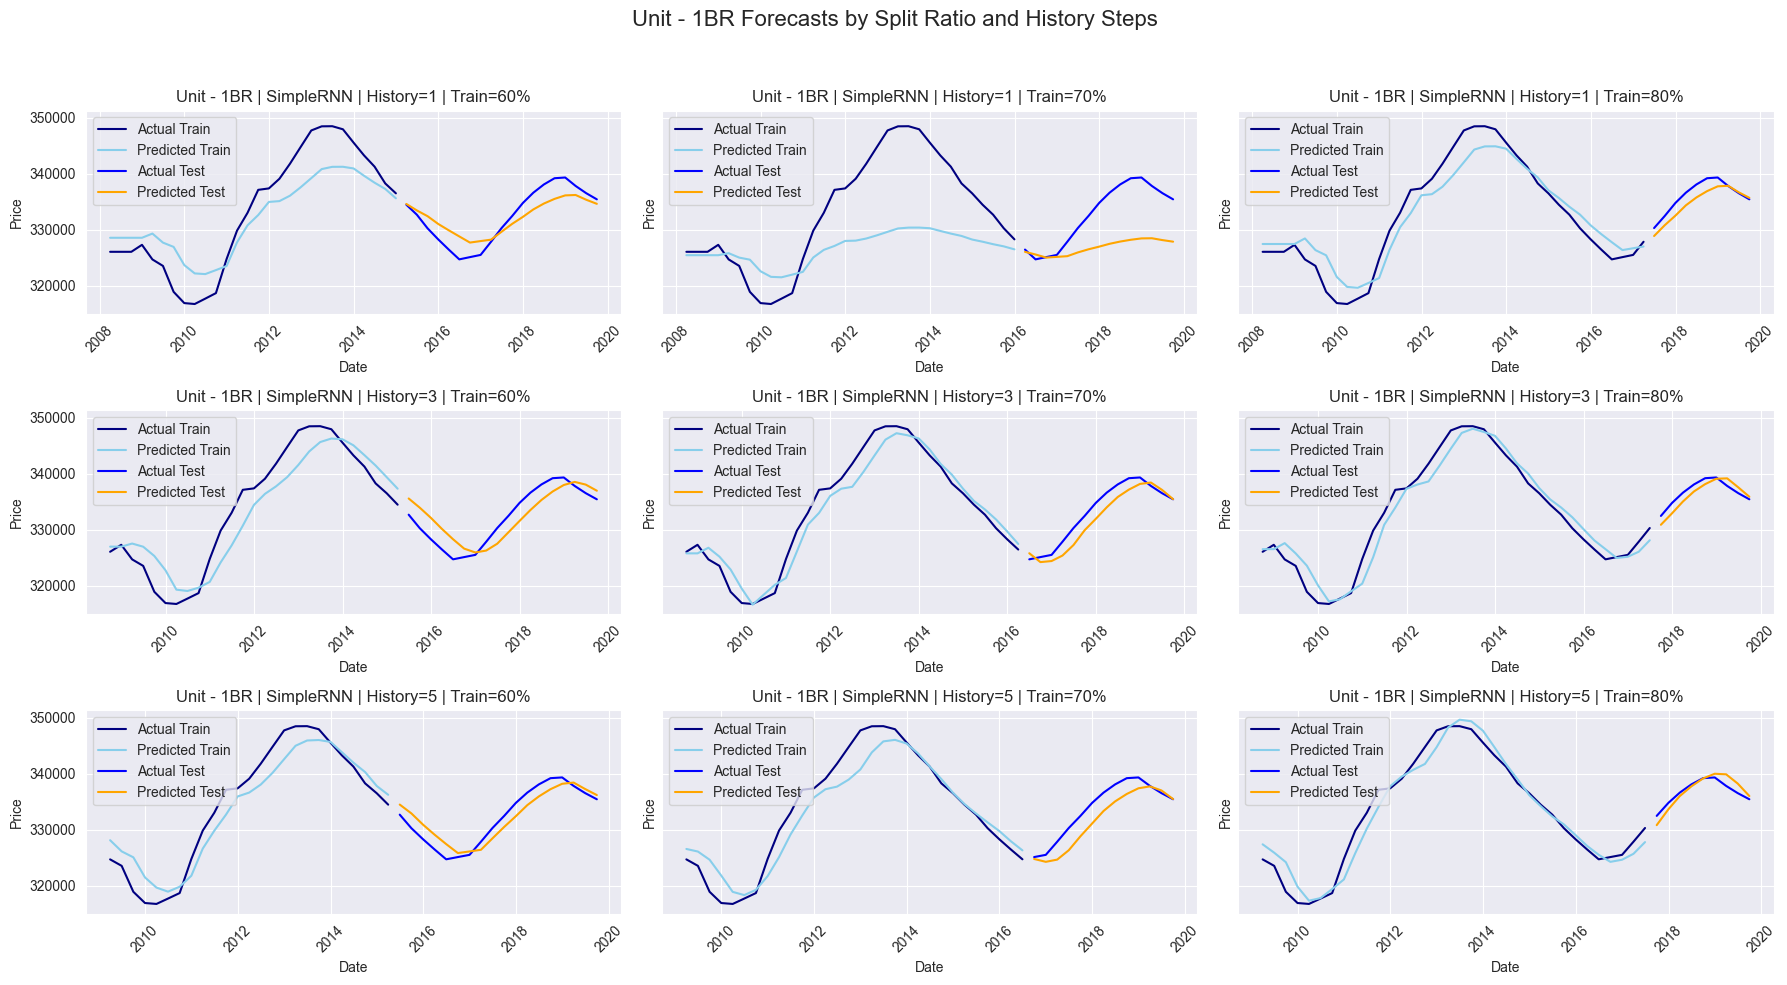

In [44]:
plot_all_combos(df_unit[(df_unit['bedrooms'] == 1)], group_label='Unit - 1BR', model_flag=True)

#### LSTM's

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
Train RMSE: 17516.15 | Test RMSE: 14323.36 | History Steps: 1 | Train Size: 60%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
Train RMSE: 19299.15 | Test RMSE: 16588.86 | History Steps: 1 | Train Size: 70%
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Train RMSE: 16550.90 | Test RMSE: 17501.64 | History Steps: 1 | Train Size: 80%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
Train RMSE: 16577.83 | Test RMSE: 13172.40 | History Steps: 3 | Train Size: 60%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
Train RMSE: 18373.32 | Test RMSE: 16060.90 | History Steps: 3 | Train Size: 70%
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Train RMSE: 6281.26 | Test RMSE: 6629.13 | History Steps: 3 | Train Size: 80%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

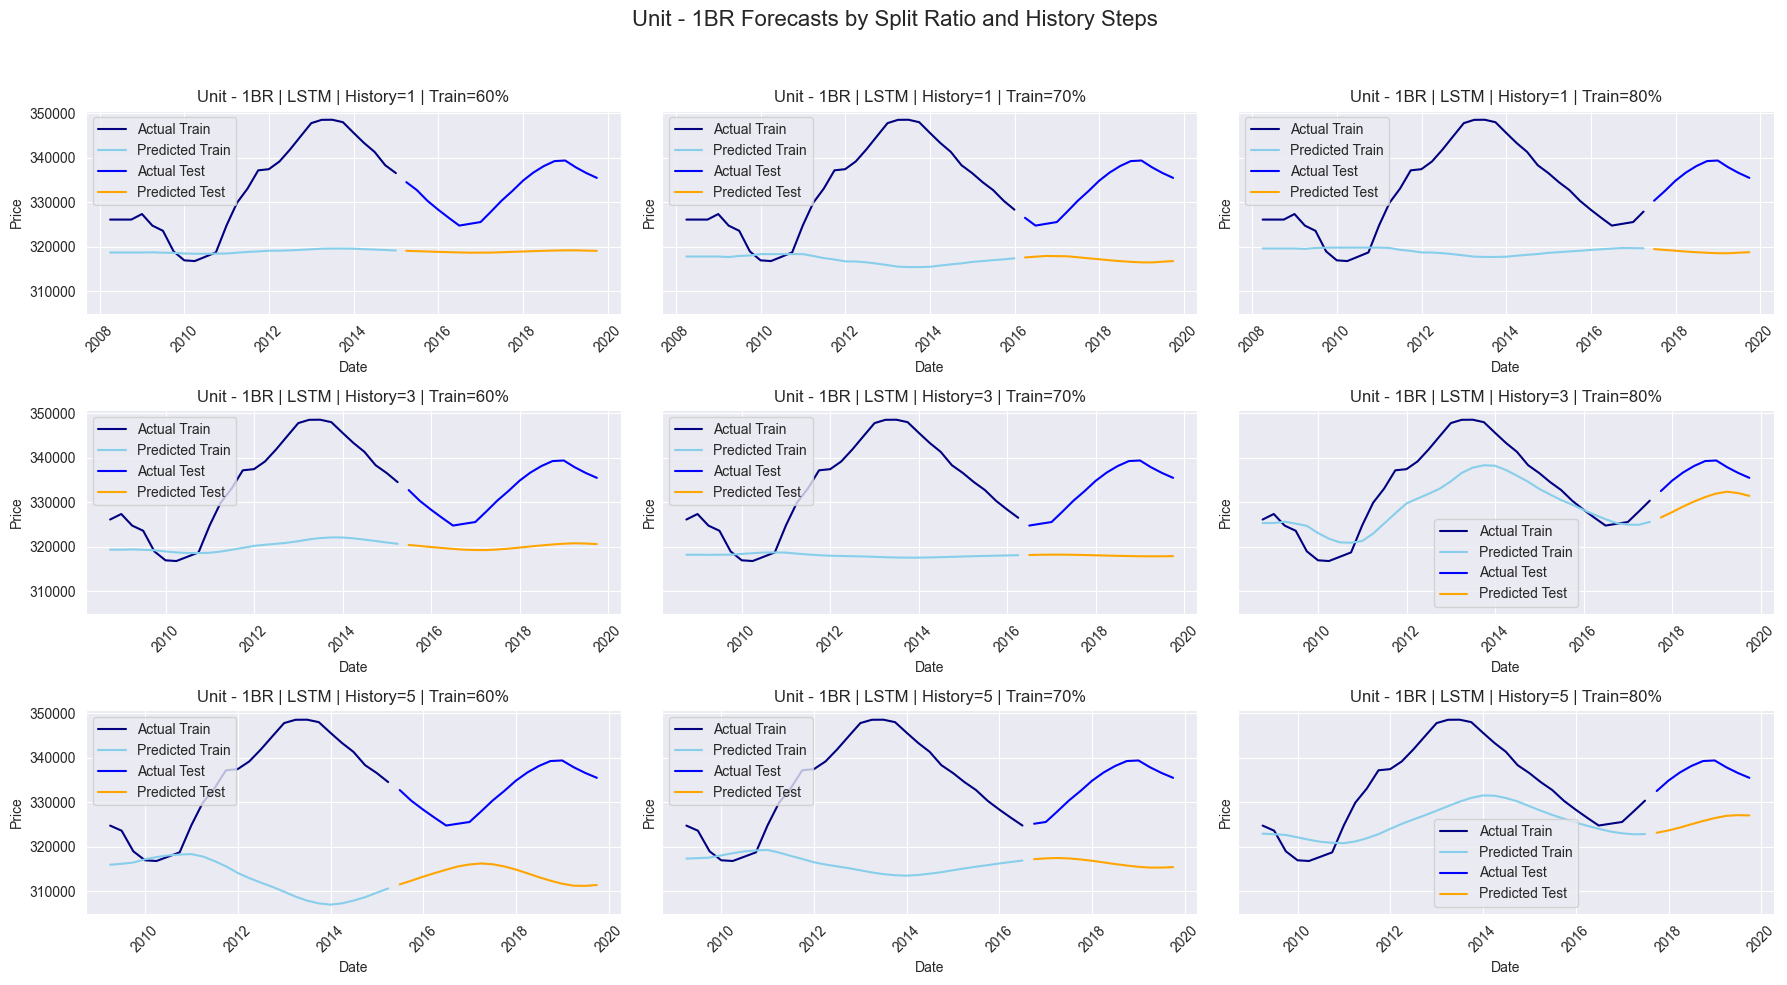

In [45]:
plot_all_combos(df_unit[(df_unit['bedrooms'] == 1)], group_label='Unit - 1BR', model_flag=False)

### 2-Bedrooms

#### RNN's

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
Train RMSE: 26448.83 | Test RMSE: 37797.46 | History Steps: 1 | Train Size: 60%
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Train RMSE: 7614.96 | Test RMSE: 3376.12 | History Steps: 1 | Train Size: 70%
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Train RMSE: 28369.41 | Test RMSE: 33453.48 | History Steps: 1 | Train Size: 80%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
Train RMSE: 3033.33 | Test RMSE: 2385.96 | History Steps: 3 | Train Size: 60%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
Train RMSE: 3795.99 | Test RMSE: 587.17 | History Steps: 3 | Train Size: 70%
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Train RMSE: 1764.14 | Test RMSE: 1612.54 | History Steps: 3 | Train Size: 80%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/st

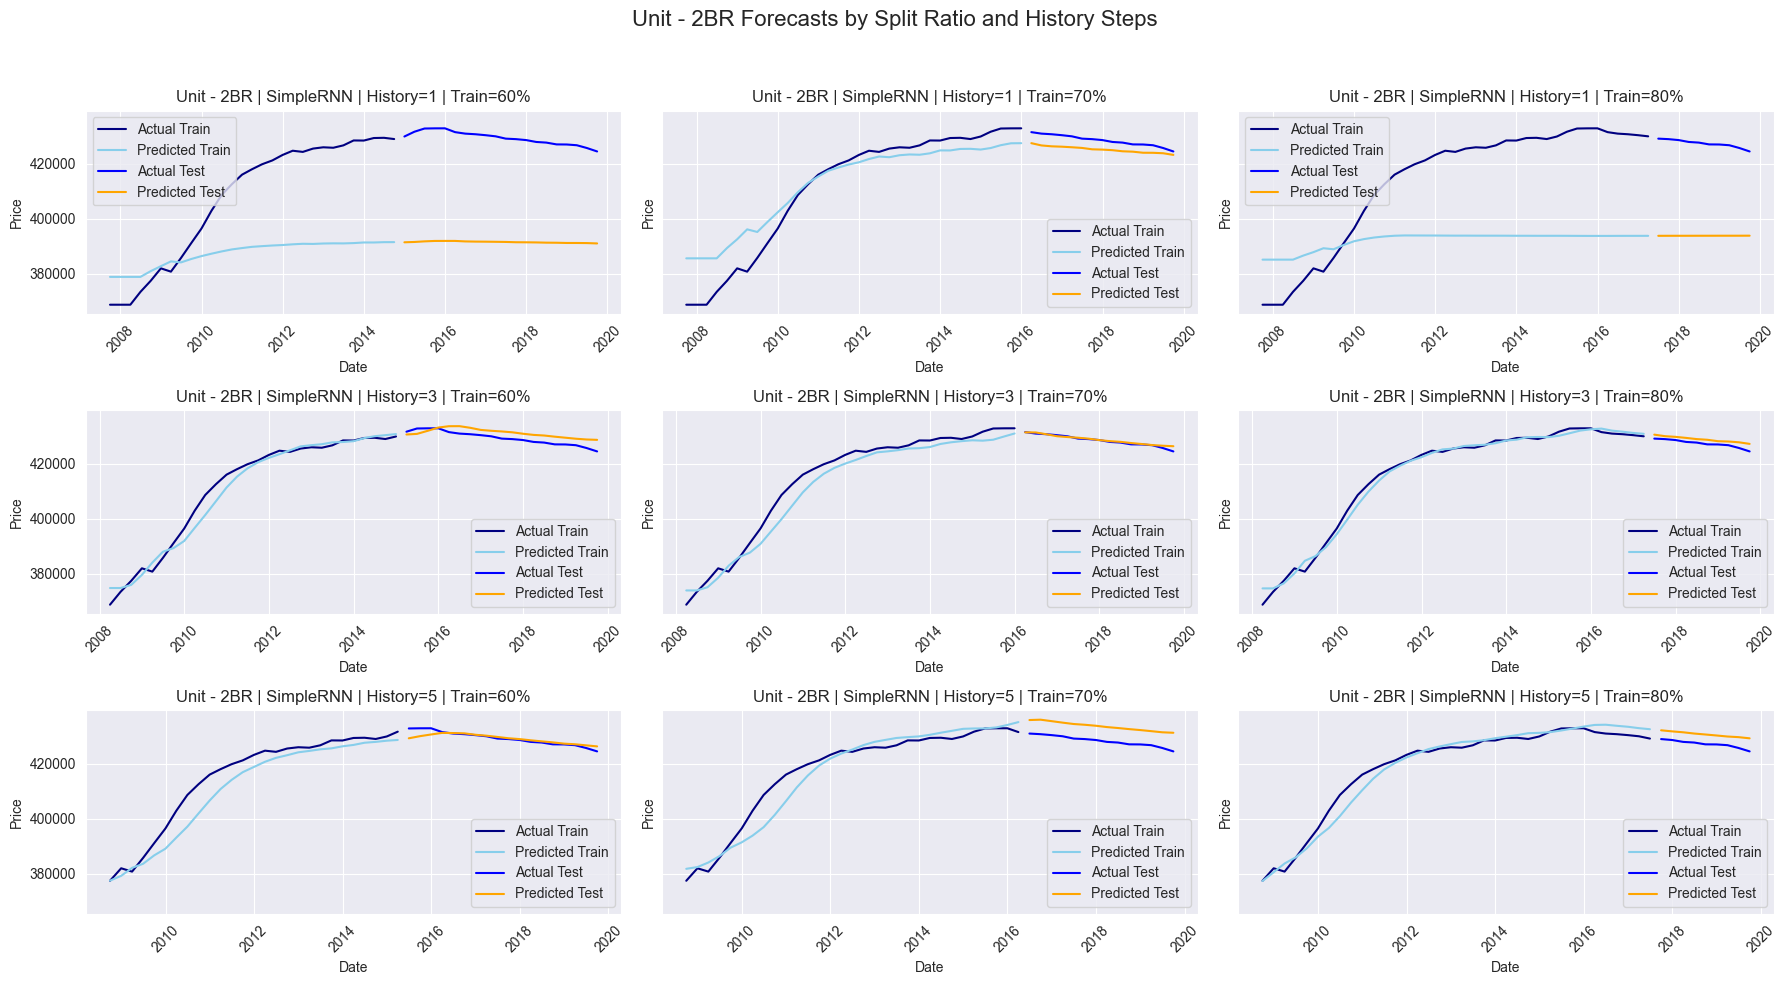

In [46]:
plot_all_combos(df_unit[(df_unit['bedrooms'] == 2)], group_label='Unit - 2BR', model_flag=True)

#### LSTM's

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
Train RMSE: 33490.25 | Test RMSE: 45731.33 | History Steps: 1 | Train Size: 60%
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Train RMSE: 41082.43 | Test RMSE: 52054.08 | History Steps: 1 | Train Size: 70%
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Train RMSE: 45646.93 | Test RMSE: 54213.65 | History Steps: 1 | Train Size: 80%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
Train RMSE: 53751.87 | Test RMSE: 72077.13 | History Steps: 3 | Train Size: 60%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
Train RMSE: 51895.97 | Test RMSE: 64284.04 | History Steps: 3 | Train Size: 70%
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Train RMSE: 47070.37 | Test RMSE: 54549.55 | History Steps: 3 | Train Size: 80%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━

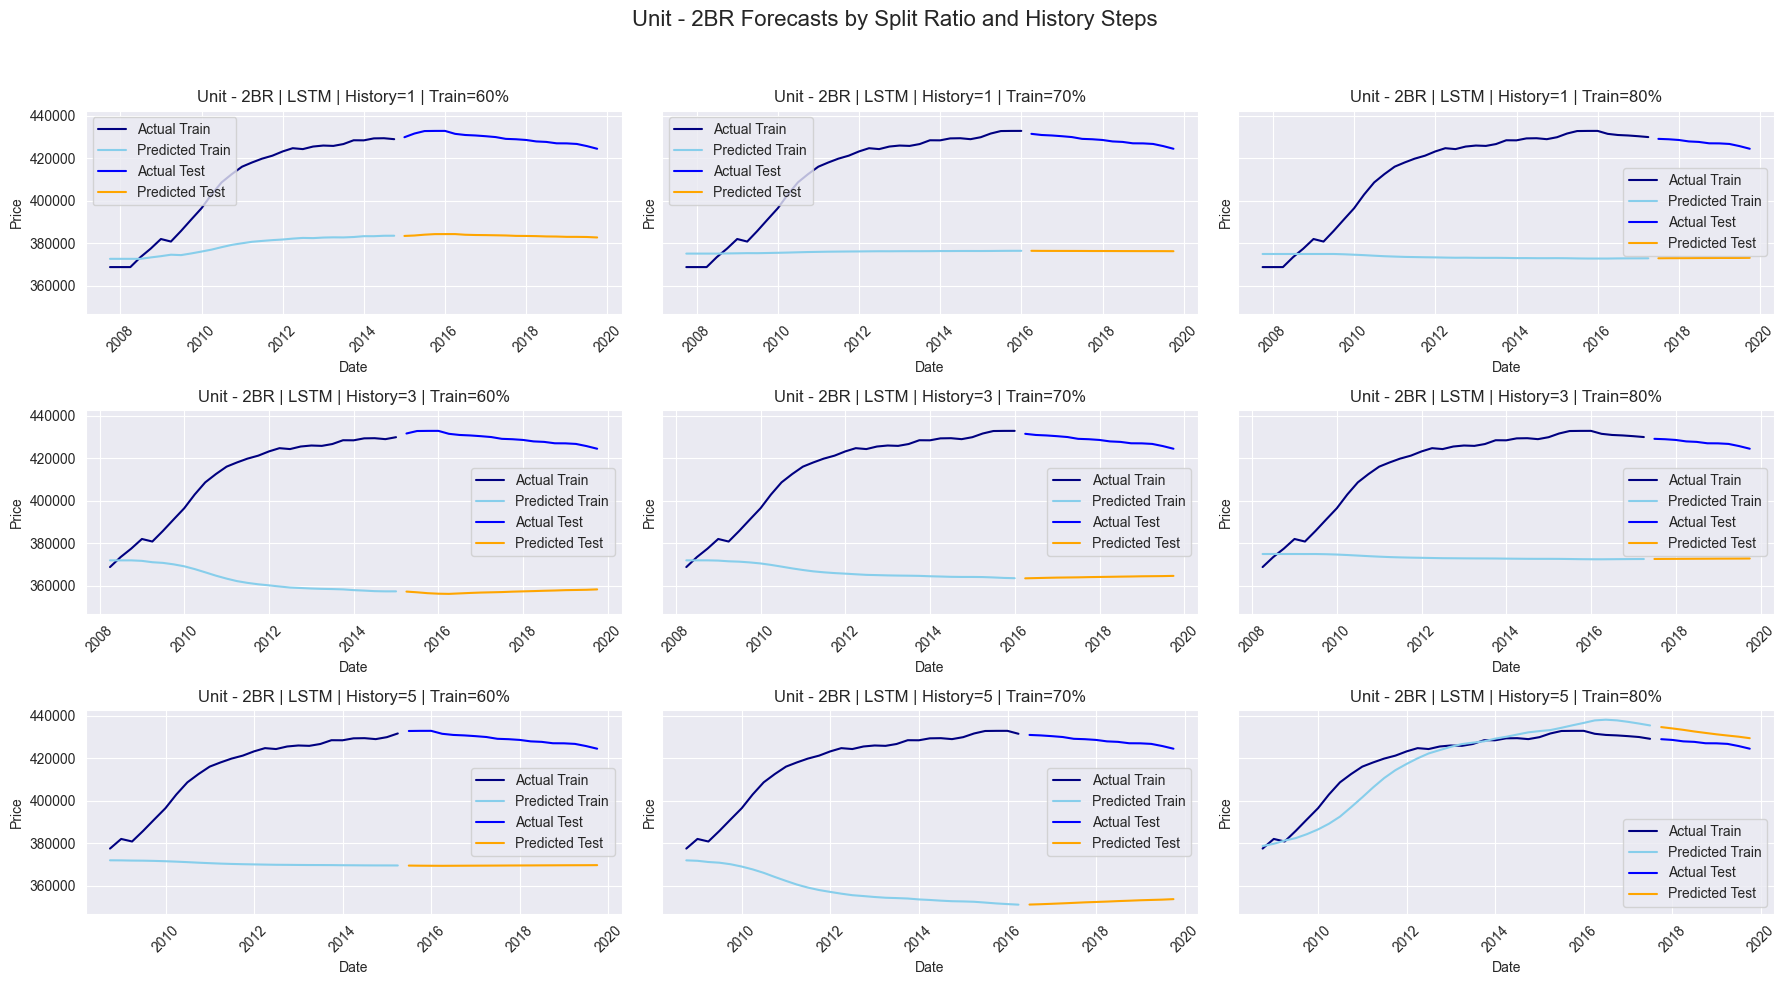

In [47]:
plot_all_combos(df_unit[(df_unit['bedrooms'] == 2)], group_label='Unit - 2BR', model_flag=False)

### 3-Bedrooms

#### RNN's

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
Train RMSE: 21026.39 | Test RMSE: 58211.90 | History Steps: 1 | Train Size: 60%
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Train RMSE: 20886.68 | Test RMSE: 29837.26 | History Steps: 1 | Train Size: 70%
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Train RMSE: 13951.29 | Test RMSE: 5787.07 | History Steps: 1 | Train Size: 80%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
Train RMSE: 8603.33 | Test RMSE: 5197.37 | History Steps: 3 | Train Size: 60%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
Train RMSE: 7025.74 | Test RMSE: 5877.09 | History Steps: 3 | Train Size: 70%
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Train RMSE: 7451.68 | Test RMSE: 2233.07 | History Steps: 3 | Train Size: 80%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/

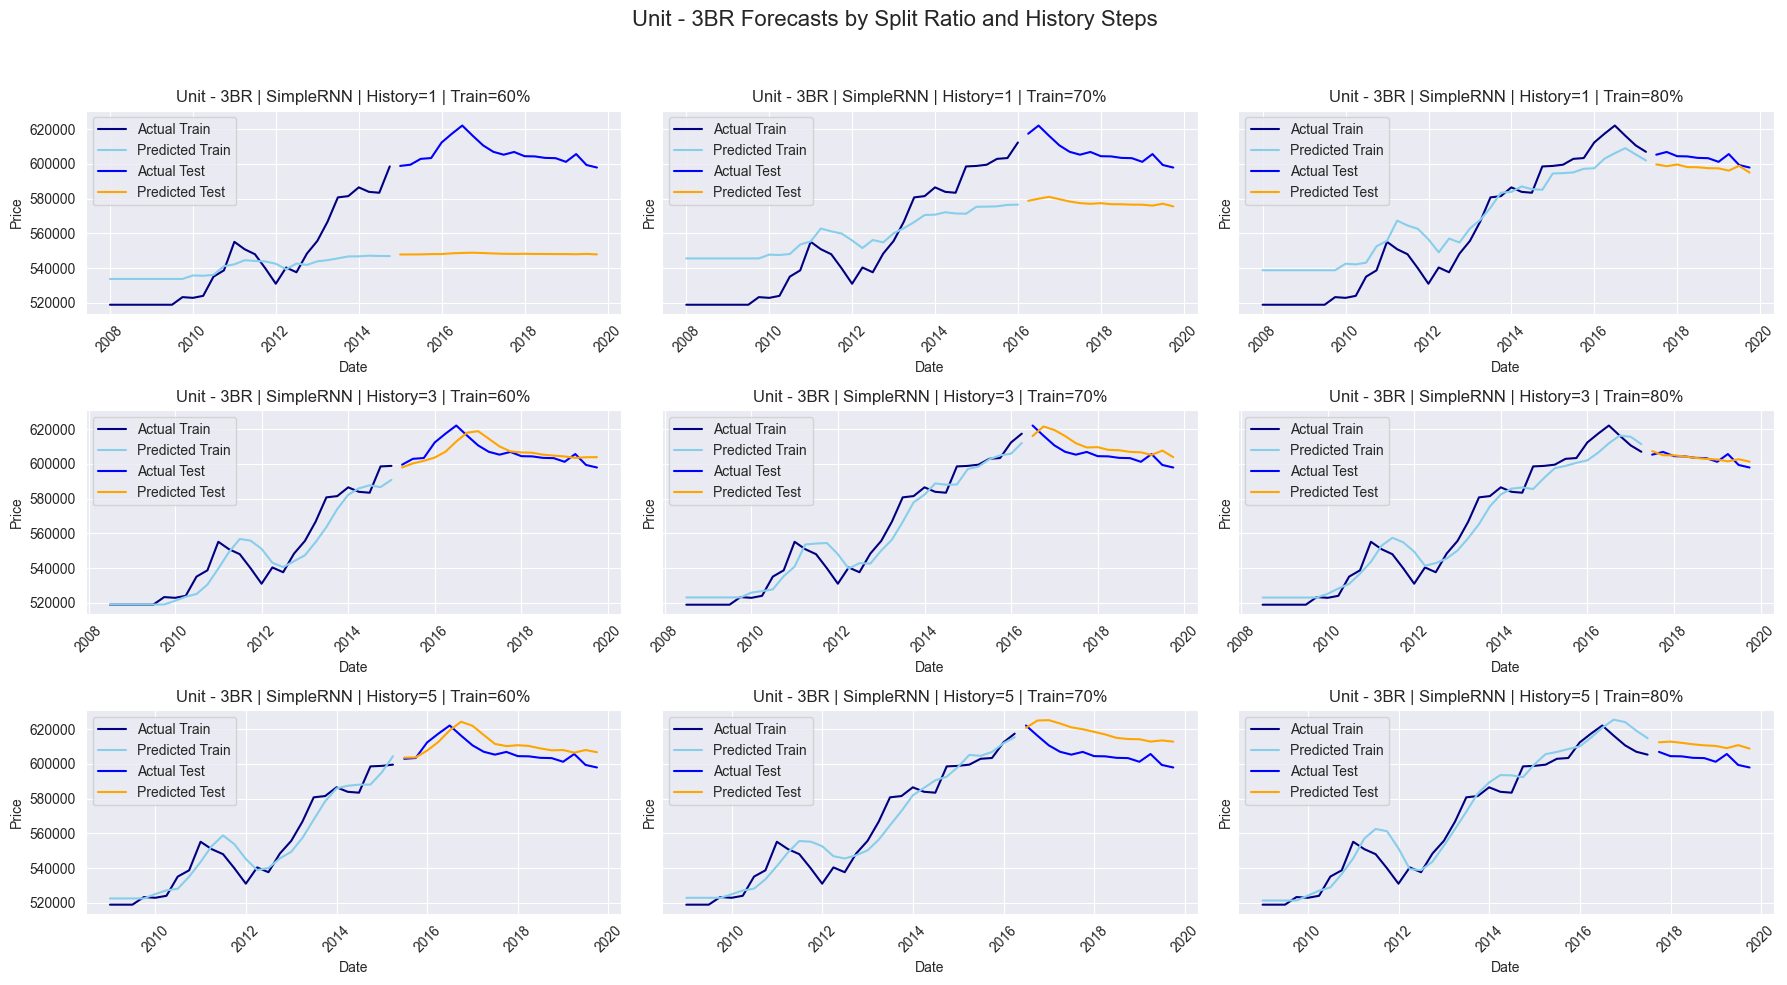

In [48]:
plot_all_combos(df_unit[(df_unit['bedrooms'] == 3)], group_label='Unit - 3BR', model_flag=True)

#### LSTM's

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
Train RMSE: 20715.44 | Test RMSE: 56725.48 | History Steps: 1 | Train Size: 60%
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Train RMSE: 18029.37 | Test RMSE: 18467.46 | History Steps: 1 | Train Size: 70%
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Train RMSE: 19251.49 | Test RMSE: 16146.17 | History Steps: 1 | Train Size: 80%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
Train RMSE: 7895.35 | Test RMSE: 7702.91 | History Steps: 3 | Train Size: 60%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
Train RMSE: 8202.72 | Test RMSE: 11518.15 | History Steps: 3 | Train Size: 70%
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Train RMSE: 7995.19 | Test RMSE: 2582.77 | History Steps: 3 | Train Size: 80%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91m

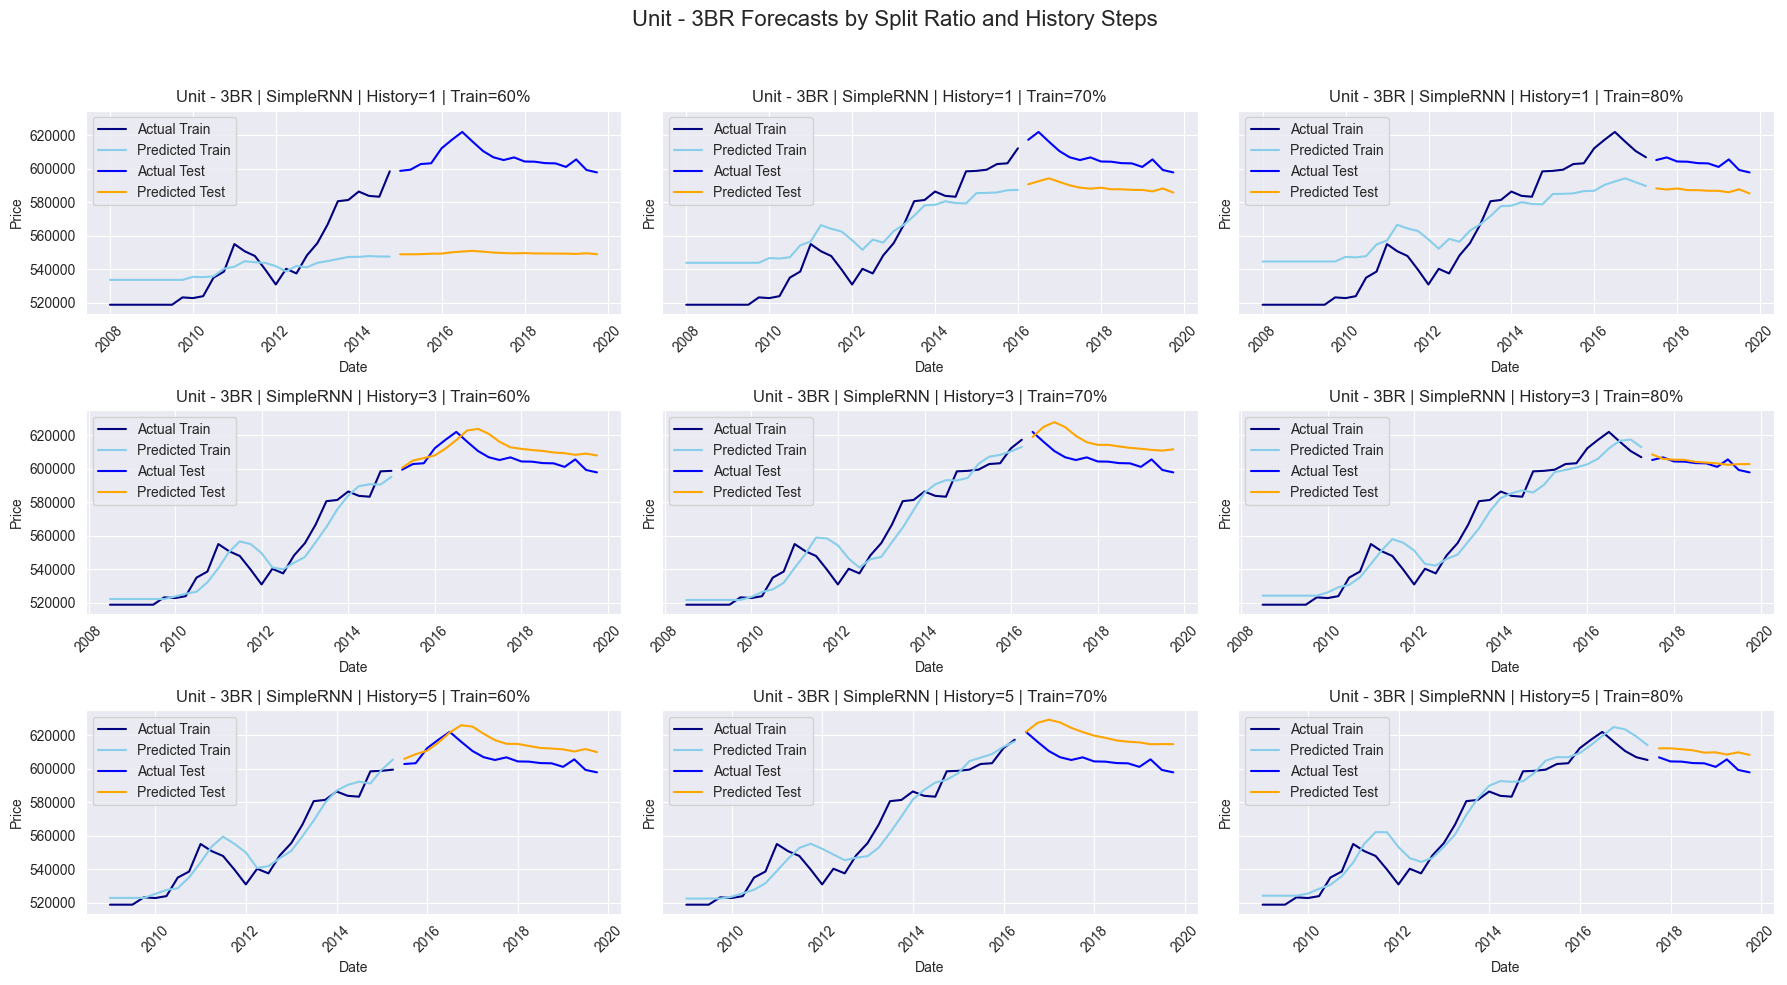

In [49]:
plot_all_combos(df_unit[(df_unit['bedrooms'] == 3)], group_label='Unit - 3BR', model_flag=True)

### Unit Price Forecasting Summary (RNN vs. LSTM)

#### One-Bedroom Units

#### SimpleRNN

- **Best configuration**: History=5, Train=80%
- **Test RMSE**: 1179.53
- Test RMSE consistently improved with:
  - Increased history steps: from 2429.75 (History=1, Train=60%) down to 1179.53 (History=5, Train=80%)
  - Increased training size

**Why this worked**: 
The 1BR price data is cyclical and smooth. RNNs benefitted from longer memory (history=5) to capture patterns like price dips and rebounds. Increasing the training set allowed better generalization without overfitting.

#### LSTM

- **Best configuration**: History=5, Train=80%
- **Test RMSE**: 11393.14
- LSTM models consistently underperformed RNNs. For example:
  - History=1, Train=60%: LSTM Test RMSE = 14323.36 vs. RNN = 2429.75
  - History=3, Train=80%: LSTM Test RMSE = 6629.13 vs. RNN = 1260.64

**Why this failed**:
LSTMs are more complex and require larger datasets. Here, they overfit to training data and failed to learn meaningful test patterns, resulting in flat predictions and poor test RMSE.

#### Two-Bedroom Units

#### SimpleRNN

- **Best configuration**: History=3, Train=70%
- **Test RMSE**: 587.17
- Notable patterns:
  - History=3 was optimal across splits
  - Test RMSEs remained under 4000 for most configurations with history ≥ 3

**Why this worked**: 
Two-bedroom unit prices followed a long-term growth curve with leveling off near 2016–2017. History steps of 3–5 were sufficient to model this trajectory. The 70% split gave enough history without truncating the test window.

#### LSTM

- **Best configuration**: History=5, Train=80%
- **Test RMSE**: 4887.84
- Most LSTM setups resulted in very high test RMSEs:
  - History=3, Train=60%: Test RMSE = 72077.13
  - History=5, Train=70%: Test RMSE = 75743.20

**Why this failed**: 
LSTMs again overfitted and underestimated trends. Some models predicted nearly flat lines in the test period, indicating they failed to extrapolate the underlying upward price curve.

#### Three-Bedroom Units

#### SimpleRNN

- **Best configuration**: History=3, Train=80%
- **Test RMSE**: 2233.07
- Strong performers:
  - History=5, Train=80%: Test RMSE = 8292.40
  - History=3, Train=70%: Test RMSE = 5877.09

**Why this worked**: 
RNNs learned price growth and deceleration well when given sufficient history and training data. History=3 provided a balance between recent trend memory and model flexibility.

#### LSTM

- **Best configuration**: History=3, Train=80%
- **Test RMSE**: 2582.77
- Stronger than LSTM results on 1BR and 2BR:
  - History=1, Train=60%: Test RMSE = 56725.48
  - History=5, Train=70%: Test RMSE = 14896.99

**Why this worked (relatively)**: 
LSTMs performed better here, likely due to the more pronounced upward trend in 3BR unit prices post-2012. Still, SimpleRNN was more stable and accurate overall.

#### Final Takeaways

1. **SimpleRNN consistently outperformed LSTM** across all unit sizes, especially in smaller data regimes.
2. **History steps of 3 or 5** were nearly always better than 1, suggesting that short-term memory is insufficient to learn housing trends.
3. **LSTMs struggled due to overfitting** and under-learning test patterns, often outputting flat or misaligned curves.
4. **Optimal configurations involved a 70% or 80% training split** with longer input sequences (history=3 to 5), which allowed models to generalize better on unseen data.
